# Проект анализа данных для "ЭкоФерма": Модели прогнозирования удоя и вкуса молока

### Описание проекта:

Перед IT-компанией поставлена задача разработки моделей машинного обучения для молочного хозяйства, которое стремится расширить своё стадо коров. Цель — отбор коров, соответствующих строгим критериям продуктивности и качества молока. 

Задания для проекта включают:

1. Разработка первой модели для прогнозирования возможного удоя коровы (целевой признак — Удой).
2. Создание второй модели для оценки вероятности получения вкусного молока от коровы (целевой признак — Вкус молока).

Отбор коров осуществляется по следующим критериям:

- Средний годовой удой должен быть не менее 6000 килограммов.
- Молоко должно соответствовать стандартам вкусовых качеств. 

Данные о коровах предоставлены партнёрами по контракту и будут использованы в моделировании для обеспечения объективности в принятии решений о покупке.

### Описание данных
Данные в файле `ferma_main.csv`:
- Характеристики коровы:
    - `id` — уникальный идентификатор коровы.
    - `Порода` — порода коровы.
    - `порода папы_быка` — порода папы коровы.
    - `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).
- Характеристики корма:
    - `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    - `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    - `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- Характеристики пастбища:
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- Характеристики молока:
    - `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    - `Жирность,%` — содержание жиров в молоке (в процентах).
    - `Белок,%` — содержание белков в молоке (в процентах).
    - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (`вкусно`, `не вкусно`).

Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:   
- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.

Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных: 
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах). Указано на момент продажи
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах). Указано на момент продажи
- `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).

Несколько особенностей по сравнению с датасетом `ferma_main.csv`:
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать!

In [1]:
import sys
!pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, precision_recall_curve
import phik

In [3]:
pd.options.mode.copy_on_write = True

## Загрузка данных

1. Загрузите данные в датафреймы `pandas`. Файлы доступны через пути:
    - `/datasets/ferma_main.csv`
    - `/datasets/ferma_dad.csv`
    - `/datasets/cow_buy.csv`
2. Изучите данные. Определите, соответствуют ли они описанию задачи и изученным в прошлых спринтах стандартам оформления данных. При необходимости переименуйте столбцы.

In [5]:
ferma = pd.read_csv('./datasets/ferma_main.csv', sep=';', decimal = ',')
dad_cows = pd.read_csv('./datasets/ferma_dad.csv', sep=';', decimal = ',')
cow_buy = pd.read_csv('./datasets/cow_buy.csv', sep=';', decimal = ',')

Для изучения данных используем функцию, которая выведет основную информацию о датафрейме и первые пять строк.

In [6]:
def get_info(data: pd.DataFrame):
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())
    print('\nInfo about duplicates:\n', data.duplicated().sum())

### Датасет про ферму

In [7]:
get_info(ferma)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    ob

Поскольку мы работаем с датафреймом, переименуем для удобства работы названия столбцов. Переименуем таким образом:
- `Удой, кг` - `yield_kg`
- `ЭКЕ (Энергетическая кормовая единица)` - `energy_feed_unit`
- `Сырой протеин, г` - `crude_protein_g`
- `СПО (Сахаро-протеиновое соотношение)` - `sugar_protein_ratio`
- `Порода` - `breed`
- `Тип пастбища` - `pasture_type`
- `порода папы_быка` - `bull_father_breed`
- `Жирность,%` - `fat_content`
- `Белок,%` - `protein`
- `Вкус молока` - `milk_taste`
- `Возраст` - `age`   

In [8]:
ferma.columns = ['id', 'yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'breed', 
                 'pasture_type', 'bull_father_breed', 'fat_content', 'protein', 'milk_taste', 'age']

Проверим, что переименование произошло успешно

In [9]:
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   yield_kg             634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   crude_protein_g      634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   bull_father_breed    634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  milk_taste           634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [10]:
ferma.head(5)

id  yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1      5863              14.2             1743                0.890   
1   2      5529              12.8             2138                0.890   
2   3      5810              14.0             1854                0.885   
3   4      5895              12.4             2012                0.885   
4   5      5302              12.8             1675                0.885   

             breed pasture_type bull_father_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное            Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинные           Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое           Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое            Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинные           Соверин         3.73    3.073   

  milk_taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

Посмотрим так же на строки с дубликатами

In [11]:
ferma.loc[ferma.duplicated()]

id  yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
629  627      5970              14.4             1837                 0.88   
630  627      5970              14.4             1837                 0.88   
631  627      5970              14.4             1837                 0.88   
632  627      5970              14.4             1837                 0.88   
633  627      5970              14.4             1837                 0.88   

               breed pasture_type bull_father_breed  fat_content  protein  \
629  РефлешнСоверинг    Холмистое           Соверин         3.64    3.075   
630  РефлешнСоверинг    Холмистое           Соверин         3.64    3.075   
631  РефлешнСоверинг    Холмистое           Соверин         3.64    3.075   
632  РефлешнСоверинг    Холмистое           Соверин         3.64    3.075   
633  РефлешнСоверинг    Холмистое           Соверин         3.64    3.075   

    milk_taste          age  
629  не вкусно  более_2_лет  
630  не вкусно  более_2_лет  
631  не вкусно  более_2_лет  
632  не вкусно  более_2_лет  
633  не вкусно  более_2_лет

Вероятно информация об одной и той же корове была занесена пять раз. На следующем этапе лишние необходимо будет удалить

### Датасет про имена отцов коров

Рассмотрим теперь датафрейм с данными о именах отцов коров:

In [12]:
get_info(dad_cows)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB

Info about missing data:
 id          0
Имя Папы    0
dtype: int64

Info about duplicates:
 0


In [13]:
dad_cows.columns = ['id', 'dad_name']

В данном датафрейме отсутствуют дубликаты или пропуски. Для удобства переименуем столбец `Имя Папы` в `dad_name`. Посмотрим на первые пять строчек в датафрейме

In [14]:
dad_cows.head()

id  dad_name
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

### Датасет про коров, которые предназначены для покупки

Рассмотрим какие данные представлены в датасете и произведем при необходимости переименование столбцов

In [15]:
get_info(cow_buy)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB

Info about missing data:
 Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Info about duplicates:
 4


In [16]:
cow_buy.columns = ['breed', 'pasture_type', 'bull_father_breed', 'dad_name', 'fat_content_now', 'protein_now', 'age']

Рассмотрим внимательнее какие данные представлены как дубликаты

In [17]:
cow_buy[cow_buy.duplicated()]

breed pasture_type bull_father_breed  dad_name  fat_content_now  \
6    Вис Бик Айдиал    холмистое            Айдиал  Геркулес             3.58   
8   РефлешнСоверинг    равнинное           Соверин     Барин             3.59   
14  РефлешнСоверинг    равнинное           Соверин     Барин             3.59   
19  РефлешнСоверинг    равнинное            Айдиал    Буйный             3.64   

    protein_now          age  
6         3.076  более_2_лет  
8         3.074  более_2_лет  
14        3.074  более_2_лет  
19        3.074  более_2_лет

При детальном рассмотрении мы видим, что полностью совпадают строки 4. На следующем этапе строки с полностью повторящихся элементами необходимо удалить

Рассмотрим так же пять первых строчек для анализа

In [18]:
cow_buy.head()

breed pasture_type bull_father_breed  dad_name  fat_content_now  \
0   Вис Бик Айдиал    холмистое            Айдиал  Геркулес             3.58   
1   Вис Бик Айдиал    равнинное           Соверин    Буйный             3.54   
2  РефлешнСоверинг    равнинное           Соверин     Барин             3.59   
3  РефлешнСоверинг    холмистое            Айдиал    Буйный             3.40   
4  РефлешнСоверинг    равнинное            Айдиал    Буйный             3.64   

   protein_now          age  
0        3.076  более_2_лет  
1        3.081  менее_2_лет  
2        3.074  более_2_лет  
3        3.061  более_2_лет  
4        3.074  более_2_лет

**Вывод**:
 - В датафрейме ferma отсутствуют пропуски, однако имеются 5 дубликатов. Далее во время предобработки данных будет необходимо изменить тип данных для столбцов со значениями с плавающей точкой. Для удобства использования были переименованы столбцы на латиницу без лишних пробелов:
    - `Удой, кг` - `yield_kg`
    - `ЭКЕ (Энергетическая кормовая единица)` - `energy_feed_unit`
    - `Сырой протеин, г` - `crude_protein_g`
    - `СПО (Сахаро-протеиновое соотношение)` - `sugar_protein_ratio`
    - `Порода` - `breed`
    - `Тип пастбища` - `pasture_type`
    - `порода папы_быка` - `bull_father_breed`
    - `Жирность,%` - `fat_content`
    - `Белок,%` - `protein`
    - `Вкус молока` - `milk_taste`
    - `Возраст` - `age`
 - В датафрейме про отцов коров нет дубликатов и пропусков, имена столбцов были заменены:
     - `Имя Папы` - `dad_name`
 - В датафрейме про коров для покупки нет пропусков, однако есть 4 дубликата, которые необходимо убрать. Была произведена замена имен столбцов на:
     - `Порода` - `breed`
     - `Тип пастбища` - `pasture_type`
     - `порода папы_быка` - `bull_father_breed`
     - `Имя Папы` - `dad_name`
     - `Текущая_жирность,%` - `fat_content_now`
     - `Текущий_уровень_белок,%` - `milk_taste`
     - `Возраст` - `age`
 - Далее будем менять тип данных, удалять пропуски и рассматривать другие проблемы с данными

##  Предобработка данных

Проверьте данные на наличие пропусков и дубликатов. Узнайте, корректны ли типы данных у каждого признака. При необходимости устраните все проблемы с данными.

Поскольку у нас могут быть неявные дубликаты, напишем функцию, которая будет принимать на вход датафрейм и его инетересующие столбцы и выводить уникальные значения для каждого столбца.

In [19]:
def field_unique(df: pd.DataFrame, features: list) -> None:
    for feature in features:
        print(f'{df[feature].value_counts()}\n')

### Датасет про ферму

Рассмотрим еще раз данные о коровах, расположенных на ферме

In [20]:
ferma.head()

id  yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1      5863              14.2             1743                0.890   
1   2      5529              12.8             2138                0.890   
2   3      5810              14.0             1854                0.885   
3   4      5895              12.4             2012                0.885   
4   5      5302              12.8             1675                0.885   

             breed pasture_type bull_father_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное            Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинные           Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое           Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое            Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинные           Соверин         3.73    3.073   

  milk_taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

Рассмотрим какие значения имеются в стоблцах `milk_taste` и `age`. На первый взгляд эти данные можно изменить на тип bool

In [21]:
ferma['milk_taste'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [22]:
ferma['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Так же удалим дубликаты, которые мы обнаружили на предыдущем шаге:

In [23]:
ferma.drop_duplicates(inplace=True, keep='first')

In [24]:
ferma.duplicated().sum()

0

In [25]:
ferma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   yield_kg             629 non-null    int64  
 2   energy_feed_unit     629 non-null    float64
 3   crude_protein_g      629 non-null    int64  
 4   sugar_protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture_type         629 non-null    object 
 7   bull_father_breed    629 non-null    object 
 8   fat_content          629 non-null    float64
 9   protein              629 non-null    float64
 10  milk_taste           629 non-null    object 
 11  age                  629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


Поскольку мы ищем дубликаты в категориальных переменных, в нашу функцию для поиска неявных их и нужно передать. Сделаем это для `breed`, `pasture_type`, `bull_father_breed`

In [26]:
field_unique(ferma, ['breed', 'pasture_type', 'bull_father_breed'])

breed
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: count, dtype: int64

pasture_type
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64

bull_father_breed
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64



В результате мы обнаружили в `pasture_type` одинаковые по смыслу `Равнинное` и `Равнинные`, а так же в породах разные варианты одной и той же породы `Айдиал`. Устраним эти неявные дубликаты

In [27]:
ferma.loc[ferma['pasture_type'] == 'Равнинные', 'pasture_type'] = 'Равнинное'
ferma.loc[ferma['bull_father_breed'] == 'Айдиалл', 'bull_father_breed'] = 'Айдиал'

In [28]:
ferma['pasture_type'] = ferma['pasture_type'].str.lower()

### Датасет про имена отцов коров

В данном датасете типы данных указаны верно, пропуски и дубликаты отстутсвуют, это было выяснено на предыдущем шаге. Поэтому дополнительных манипуляций с этим датафреймом делать нет необходимости. Рассмотрим только какие отцовские имена присутствуют в датафреме 

In [29]:
dad_cows['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [30]:
dad_cows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Проведем проверку на неявные дубликаты:

In [31]:
field_unique(dad_cows, ['dad_name'])

dad_name
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64



### Датасет про коров, которые предназначены для покупки

Для данного датасета необходимо провести замену типов данных, а так же удалить дубликаты, которые были обнаружены на первом шаге

In [32]:
cow_buy.head()

breed pasture_type bull_father_breed  dad_name  fat_content_now  \
0   Вис Бик Айдиал    холмистое            Айдиал  Геркулес             3.58   
1   Вис Бик Айдиал    равнинное           Соверин    Буйный             3.54   
2  РефлешнСоверинг    равнинное           Соверин     Барин             3.59   
3  РефлешнСоверинг    холмистое            Айдиал    Буйный             3.40   
4  РефлешнСоверинг    равнинное            Айдиал    Буйный             3.64   

   protein_now          age  
0        3.076  более_2_лет  
1        3.081  менее_2_лет  
2        3.074  более_2_лет  
3        3.061  более_2_лет  
4        3.074  более_2_лет

In [33]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   breed              20 non-null     object 
 1   pasture_type       20 non-null     object 
 2   bull_father_breed  20 non-null     object 
 3   dad_name           20 non-null     object 
 4   fat_content_now    20 non-null     float64
 5   protein_now        20 non-null     float64
 6   age                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [34]:
cow_buy.drop_duplicates(inplace=True, keep='first')

Проведем так же проверку на неявные дубликаты для категориальных признаков

In [35]:
field_unique(cow_buy, ['breed', 'pasture_type', 'bull_father_breed', 'dad_name'])

breed
Вис Бик Айдиал     8
РефлешнСоверинг    8
Name: count, dtype: int64

pasture_type
холмистое    8
равнинное    8
Name: count, dtype: int64

bull_father_breed
Соверин    10
Айдиал      6
Name: count, dtype: int64

dad_name
Буйный      7
Геркулес    5
Барин       2
Соловчик    2
Name: count, dtype: int64



Для данного датафрейма не обнаружено неявных дубликатов, однако мы убедились в правильности внесенных изменений в первый датафрейм

Создадим так же объединенный датафрейм, чтобы посмотреть какие породы отца быка существуют

In [36]:
ferma_group = ferma[['breed', 'bull_father_breed', 'id']].merge(dad_cows, on='id')
ferma_group

breed bull_father_breed   id  dad_name
0     Вис Бик Айдиал            Айдиал    1    Буйный
1     Вис Бик Айдиал           Соверин    2  Соловчик
2    РефлешнСоверинг           Соверин    3     Барин
3    РефлешнСоверинг            Айдиал    4    Буйный
4     Вис Бик Айдиал           Соверин    5     Барин
..               ...               ...  ...       ...
624  РефлешнСоверинг            Айдиал  625    Буйный
625  РефлешнСоверинг           Соверин  626     Барин
626  РефлешнСоверинг           Соверин  627     Барин
627  РефлешнСоверинг           Соверин  628     Барин
628   Вис Бик Айдиал           Соверин  629  Соловчик

[629 rows x 4 columns]

In [37]:
ferma_group.pivot_table(columns='dad_name', index=['breed', 'bull_father_breed'], values='id', aggfunc='count', fill_value=0)

dad_name                           Барин  Буйный  Геркулес  Соловчик
breed           bull_father_breed                                   
Вис Бик Айдиал  Айдиал                10     128        54         8
                Соверин              100       0         0        73
РефлешнСоверинг Айдиал                18      87        10         3
                Соверин              112       0         0        26

Судя по созданной сводной таблице, есть некоторое нарушение среди пород отцов и коров, вероятно неверно указаны породы для Барин и Соловчик. От породы отца зависит порода самой коровы, однако измненение породы коровы на РефлешнСоверинг для потомства Барина и Соловчика очень сильно изменит датафрейм. Такое возможно, если отцы вписывались ради галочки - например, точное отцовство не установлено или на ферме имеются быки разных пород, но одинаковых имен.

По причине того, что менять половину данных не стоит, а так же неизвесты причины такого различия, стоит оставить датафрейм в исходном состоянии.

Возможно причина состоит в кроссинге коров внутри племени, из-за чего после рождения выделяют наиболее превалирующие признаки линии породы и относят корову к ней. Это может объяснить различие линий пород для отца и коровы

**Вывод**:
- Для датафрейма с данными о коровах было произведено 
    - были удалены полные дубликаты и неявные дубликаты для столбцов `bull_father_breed` и `pasture_type`
- Для датафрейма о отцах коров не было проведено дополнительных манипуляций, так как типы данных и данные указаны верно
- Для датафрейма о коровах для покупки было произведено
    - удаление дубликатов

Тем самым датасет подготовлен к дальнейшему анализу и использованию

## Исследовательский анализ данных

1. Проведите статистический анализ всех признаков.

Сначала выведем информацию про количественные признаки датафрейма `ferma`

In [38]:
ferma[['yield_kg', 'energy_feed_unit', 'crude_protein_g', 'fat_content', 'protein', 'sugar_protein_ratio']].describe()

yield_kg  energy_feed_unit  crude_protein_g  fat_content  \
count    629.000000        629.000000       629.000000   629.000000   
mean    6188.750397         14.543879      1923.364070     3.603657   
std     1644.795489          1.306408       182.956251     0.168656   
min     5204.000000         10.900000      1660.000000     2.990000   
25%     5751.000000         13.500000      1771.000000     3.590000   
50%     6133.000000         14.700000      1888.000000     3.650000   
75%     6501.000000         15.600000      2062.000000     3.720000   
max    45616.000000         16.800000      2349.000000     3.750000   

          protein  sugar_protein_ratio  
count  629.000000           629.000000  
mean     3.075671             0.913116  
std      0.002549             0.032203  
min      3.069000             0.840000  
25%      3.074000             0.890000  
50%      3.076000             0.930000  
75%      3.077000             0.940000  
max      3.085000             0.960000

Для признака `yield_kg` заметен явный выброс в виде максимума в 45616 килограмм. Поскольку это не может быть значение в граммах, стоит удалить одно это значение.

In [39]:
ferma = ferma[ferma['yield_kg'] < 40000]

А затем категориальные для датафрейма `ferma`

In [40]:
ferma[['breed', 'pasture_type', 'bull_father_breed', 'age', 'milk_taste']].describe()

breed pasture_type bull_father_breed          age milk_taste
count              628          628               628          628        628
unique               2            2                 2            2          2
top     Вис Бик Айдиал    холмистое            Айдиал  более_2_лет     вкусно
freq               372          350               317          518        370

Выведем информацию про количественные признаки датафрейма `cow_buy`

In [41]:
cow_buy[['fat_content_now', 'protein_now']].describe()

fat_content_now  protein_now
count        16.000000    16.000000
mean          3.571875     3.068250
std           0.141620     0.011264
min           3.340000     3.046000
25%           3.415000     3.059500
50%           3.585000     3.073500
75%           3.692500     3.076750
max           3.770000     3.081000

И выведем качественные признаки датафрейма `cow_buy`

In [42]:
cow_buy[['breed', 'pasture_type', 'bull_father_breed', 'dad_name', 'age']].describe()

breed pasture_type bull_father_breed dad_name          age
count               16           16                16       16           16
unique               2            2                 2        4            2
top     Вис Бик Айдиал    холмистое           Соверин   Буйный  более_2_лет
freq                 8            8                10        7           11

Выведем категориальные признаки для датафрейма `dad_cows`

In [43]:
dad_cows['dad_name'].describe()

count       629
unique        4
top       Барин
freq        240
Name: dad_name, dtype: object

2. Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.

Построим для категориальных данных bar и pie charts. Для удобства напишем функцию, которая на вход будет принимать датафрейм и признаки и на основе этих данных строить графики. В случае, если у нас одинаковое количество данных, будем просто выводить информацию, что одинаковое и количество для каждого варианта.

In [44]:
sns.set_theme()
sns.set_palette("Set2")

In [45]:
def categorial_plot(df: pd.DataFrame, title: str, features: dict) -> None:
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data = df[feature].value_counts().to_frame().reset_index()
        if len(data['count'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            fig.suptitle(f'Распределение для {feat_ru}')
            axes[0].yaxis.grid(True)
            sns.barplot(data=data, x=feature, y='count', ax=axes[0])
            axes[0].set_ylabel('Количество')
            axes[0].set_xlabel(feat_ru)
            axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
        else:
            print(f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

In [46]:
def numerical_plot(df: pd.DataFrame, title: str, features: dict):
    print(f'Графики количественных признаков для {title}')
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        sns.histplot(df[feature], kde=True, ax=axes[0], bins=30)
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Количество')
            axes[num].set_xlabel(feat_ru)

### Датасет про ферму

In [47]:
numerical_ferma = {'yield_kg': 'Удой, кг',
                    'energy_feed_unit': 'ЭКЕ (Энергетическая кормовая единица)',
                    'sugar_protein_ratio': 'СПО (Сахаро-протеиновое соотношение)',
                    'fat_content': 'Жирность,%',
                    'protein': 'Белок,%',
                    'crude_protein_g': 'Сырой протеин, г'}

Графики количественных признаков для датасета про ферму


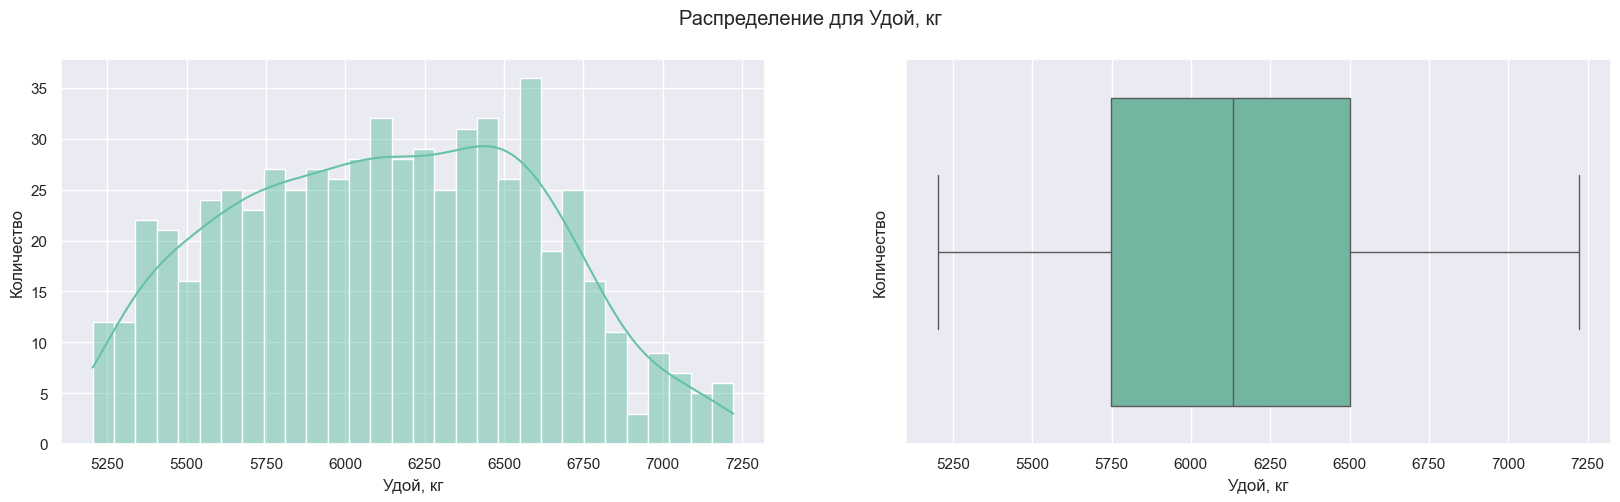

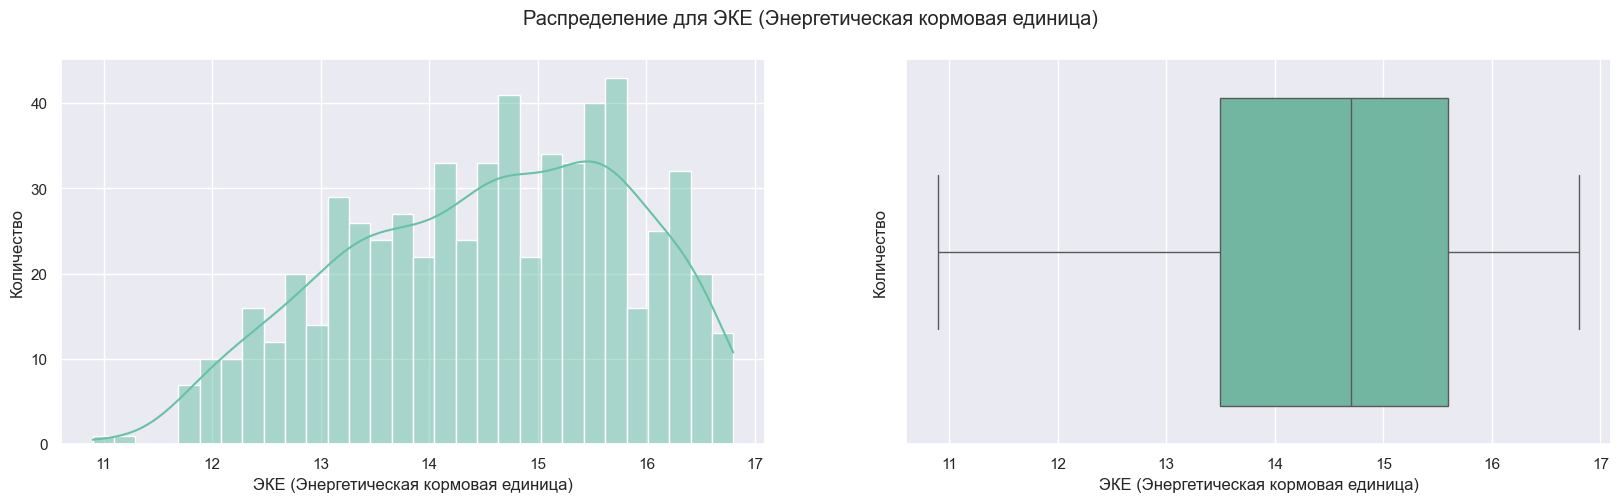

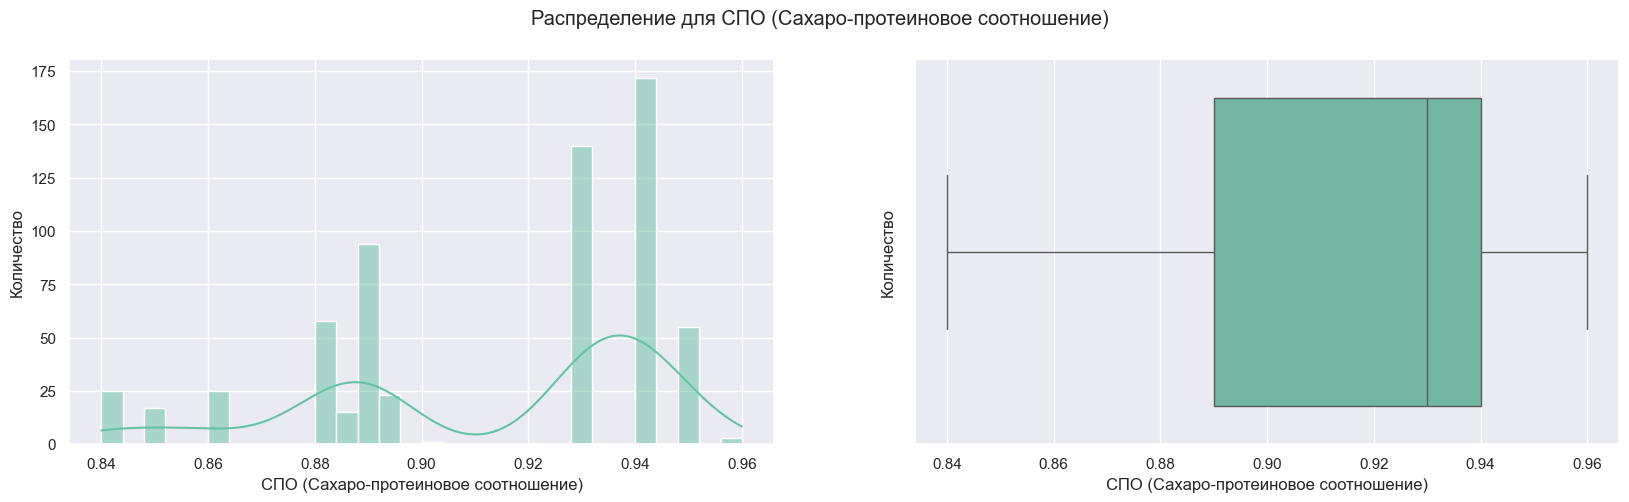

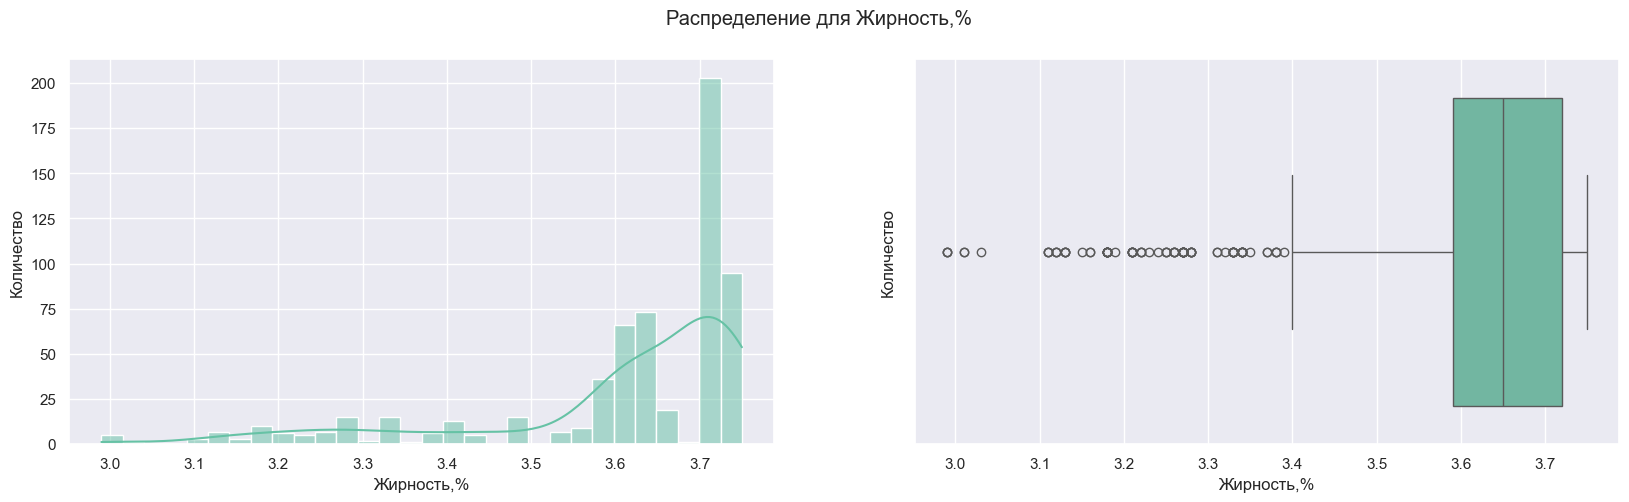

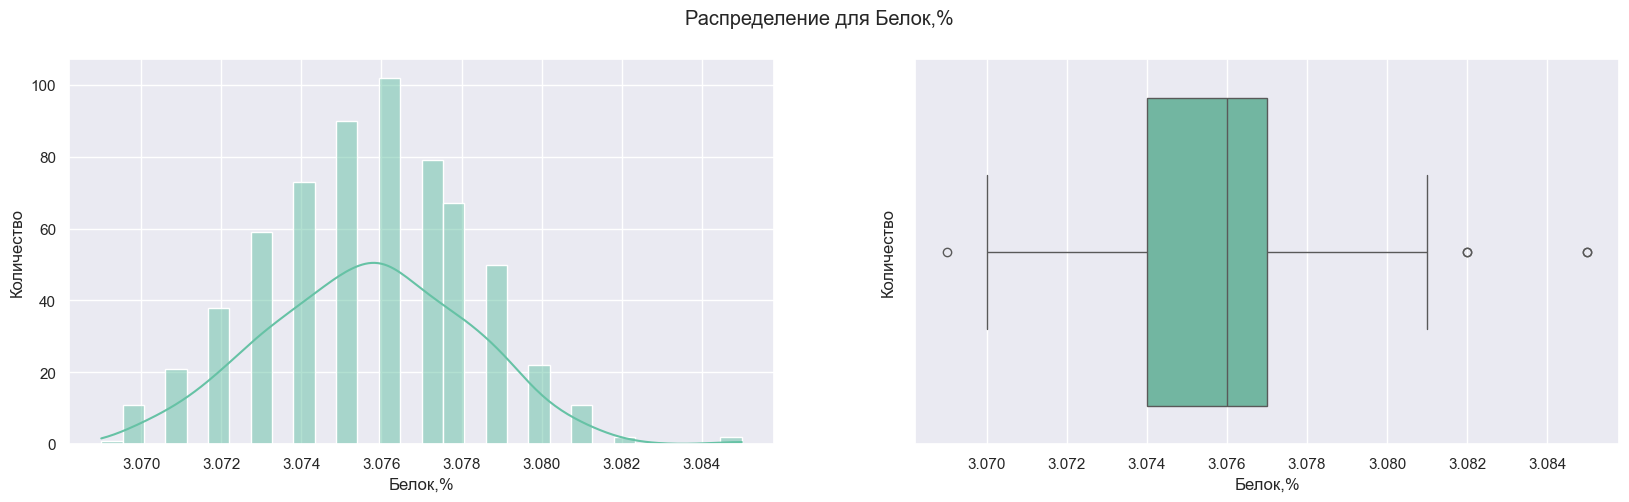

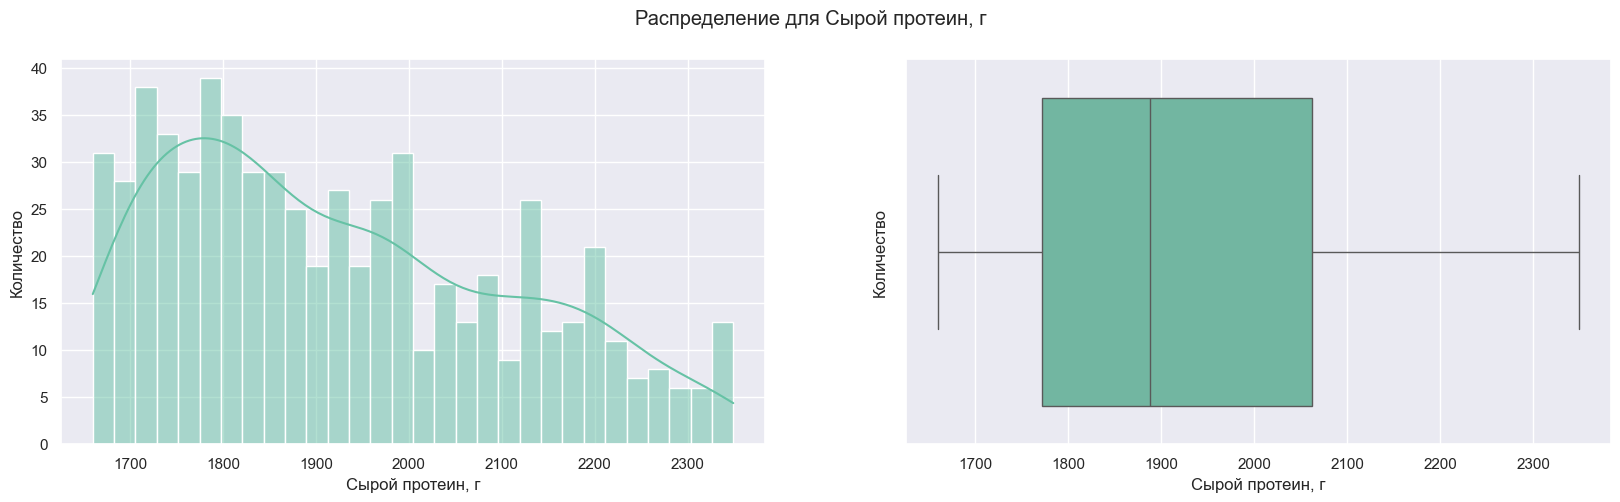

In [48]:
numerical_plot(ferma, 
               'датасета про ферму', 
               numerical_ferma)

- Для графика удоя нет выбросов, однако распределение нельзя назвать нормальным, а так же нет какого-то определенного максимума, самое большое количество значений находится в районе 6500 кг, тогда как медианное значение - 6133 кг
- Распределение ЭКЕ не является нормальным, в нем нет каких-то характерных выбросов. Его медианное значение - 14.7
- Для СПО наблюдается два максимума, в районе 0.89 и 0.93. Медианное значение является 0.93
- Жирность молока чаще всего составляет около 3.7 процентов, ее медианное значение составляет 3.65 процентов, из-за чего значениия с жирностью меньше 3.4 выпадают из дипазаона
- Процентное содержание белка очень напоминает нормальное распределение, медианное значение составляет 3.076, что совпадает с наиболее встречаемым значением. На графике боксплот наблюдается три выброса, однако различия составляют сотые доли, а значит эти значения не сильно отличаются и их можно оставить
- Для сырого протеина чаще всего значения находятся в диапазоне 1700 - 1900, медианное значение составляет 1888, выбросов на графике не наблюдается.

In [49]:
categorial_ferma = {'breed': 'Порода', 
                 'pasture_type': 'Тип пастбища', 
                 'bull_father_breed': 'порода папы_быка',
                 'age': 'Возраст', 
                 'milk_taste': 'Вкус молока'}

Графики категориальных признаков для датасета про ферму


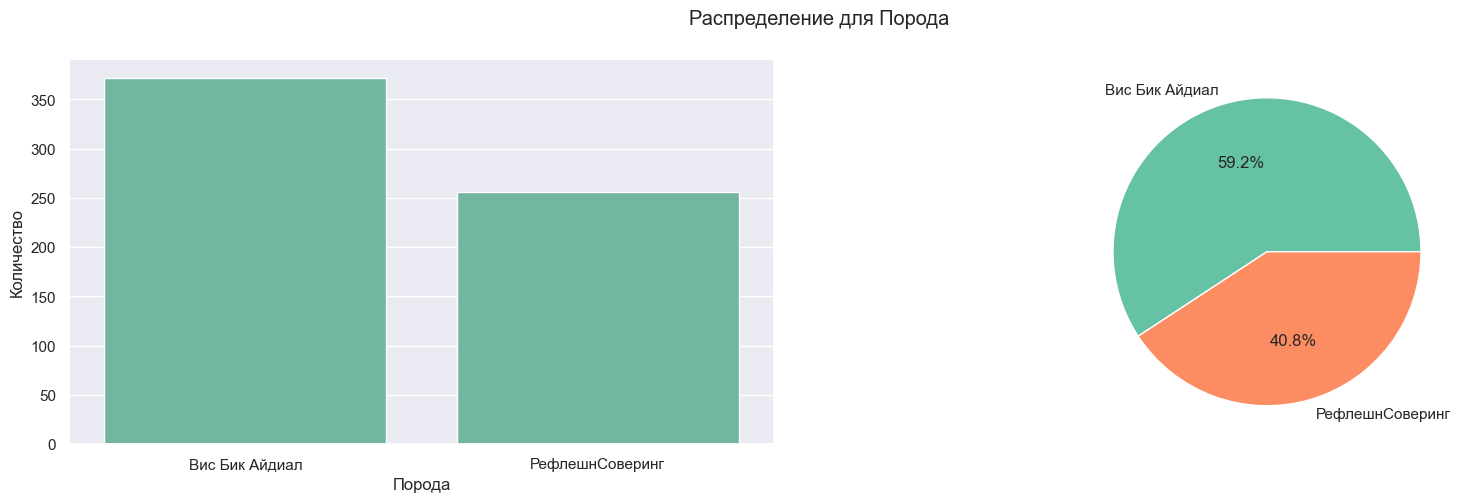

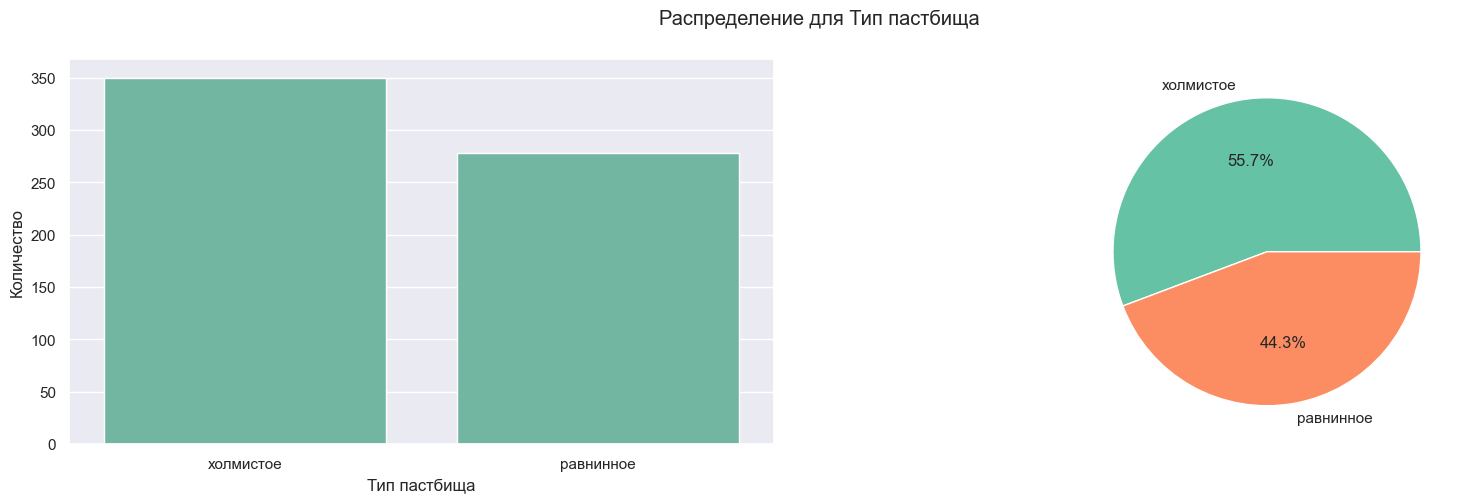

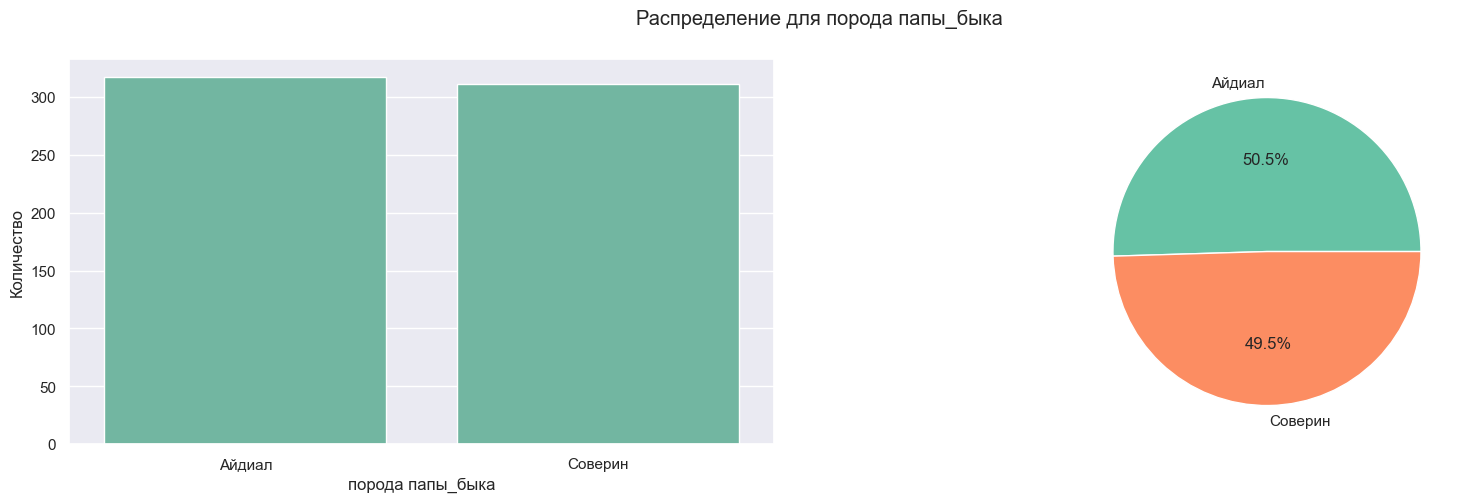

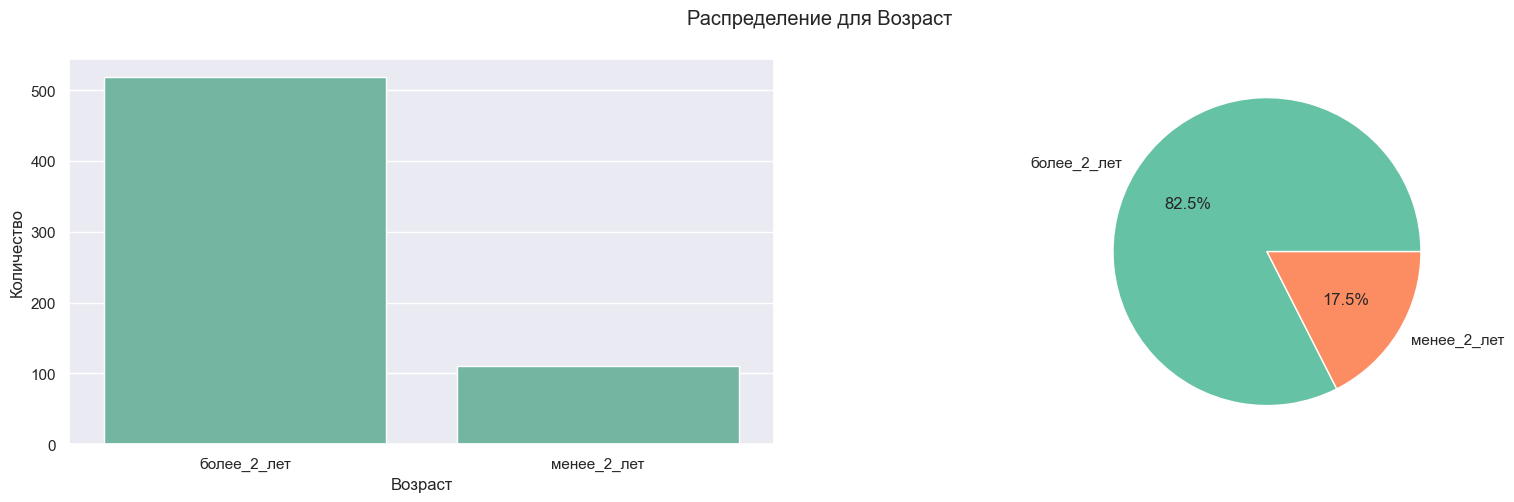

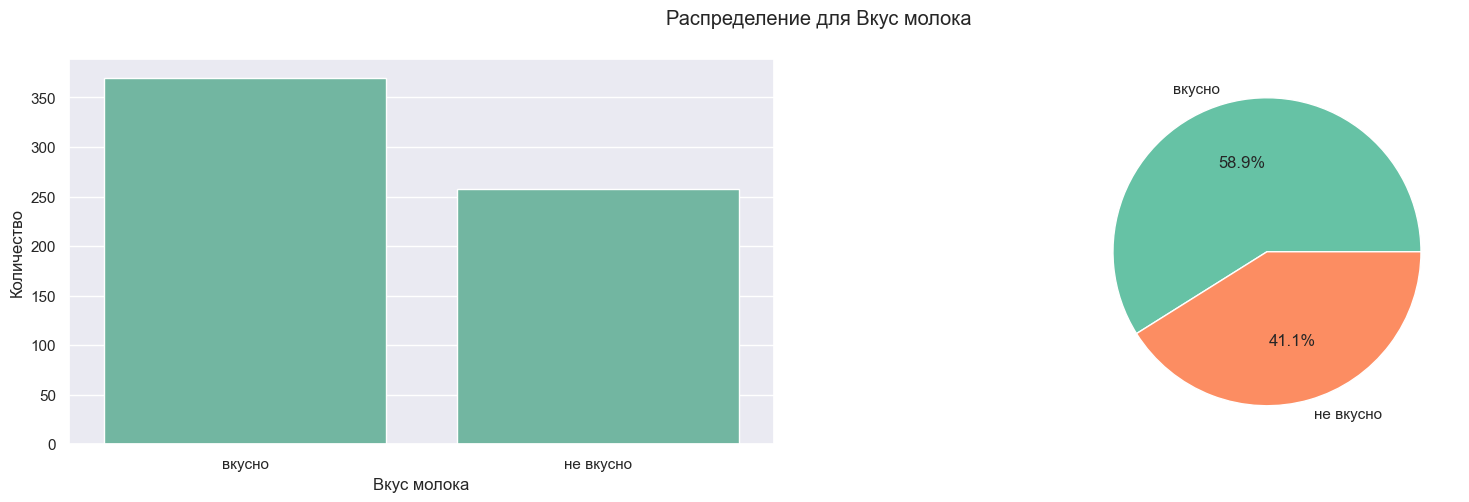

In [50]:
categorial_plot(ferma, 
                'датасета про ферму', 
                categorial_ferma)

Для категориальных признаков были построены столбчатые и круговые диаграммы
- Порода представлена в двух видах, которые разделены в соотношении 6:4 для Вис Бик Айдиал и РефлешнСоверинг соответственно
- Тип пастбища представлен в виде Холмистое и Равнинное в соотношении 11:9 соответственно
- Порода отца коровы представлена в соотношении 1:1 для Айдиал и Соверин
- Большая часть коров старше двух лет
- Вкус молока у коровы чаще всего явлется вкусным и разделяется в соотношении 6:4 для вкусно и невкусно

### Датасет про имена отцов коров

Графики категориальных признаков для датасета про имена отцов коров


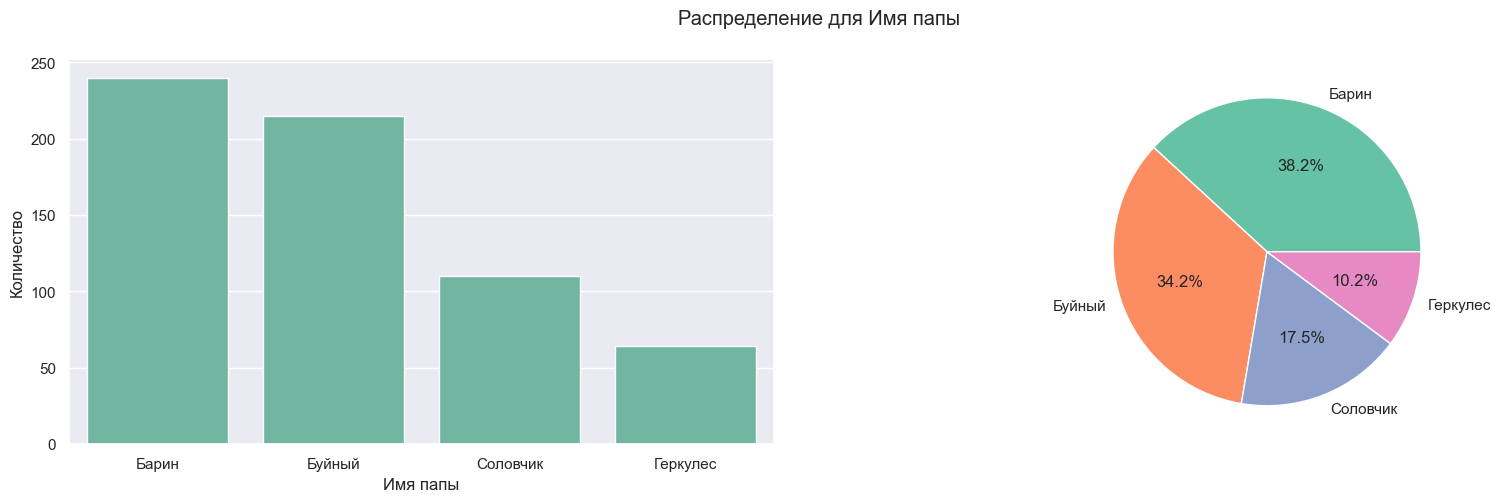

In [51]:
categorial_plot(dad_cows, 'датасета про имена отцов коров', {'dad_name': 'Имя папы'})

Построив диаграмму можно отметить, что для чаще для коров выступают отцами быки с именами Барин и Буйный, а далее идут Соловчик и Геркулес с уменьшением количества потомства от них

### Датасет про коров, которые предназначены для покупки

Графики категориальных признаков для коров, которые предназначены для покупки
Для категориального признака "Порода" одинаковое количество данных на все группы: 8
Для категориального признака "Тип пастбища" одинаковое количество данных на все группы: 8


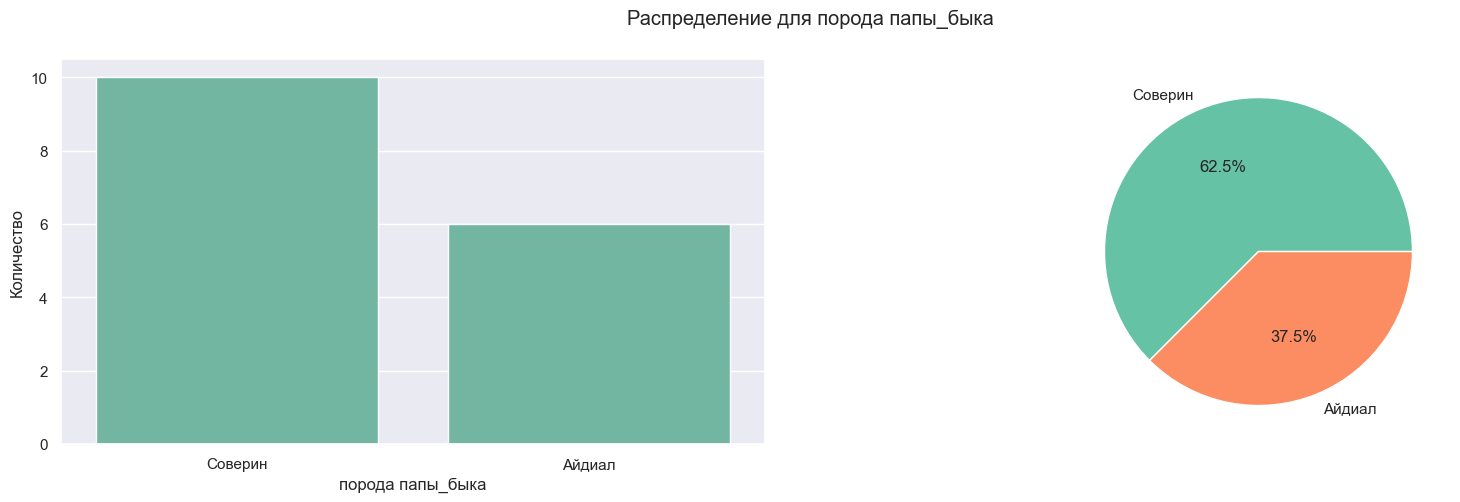

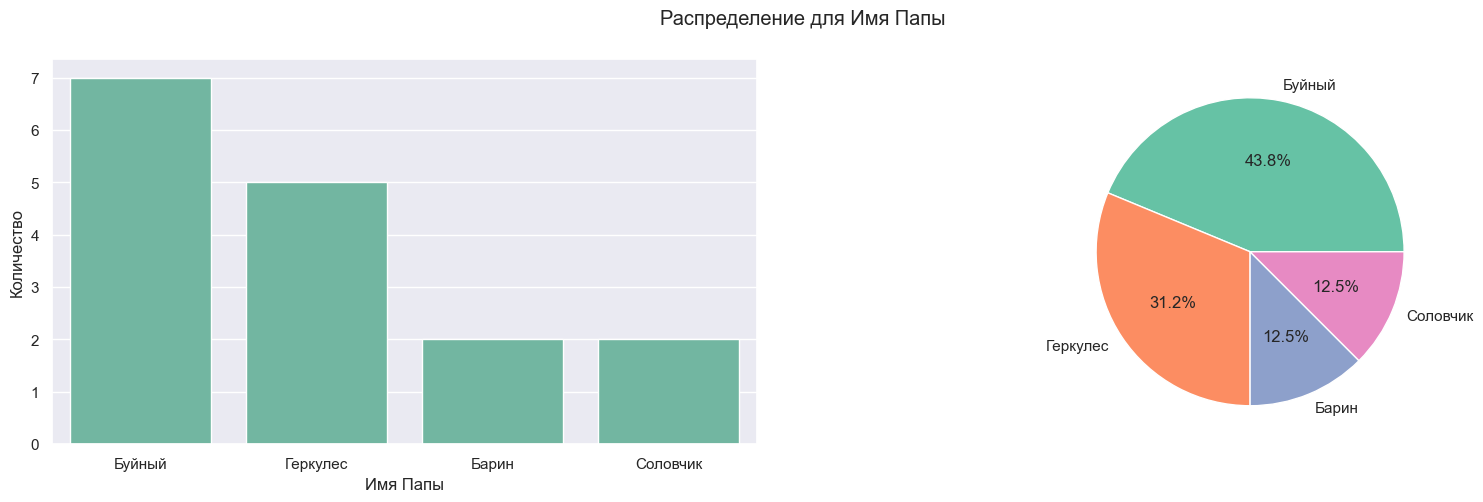

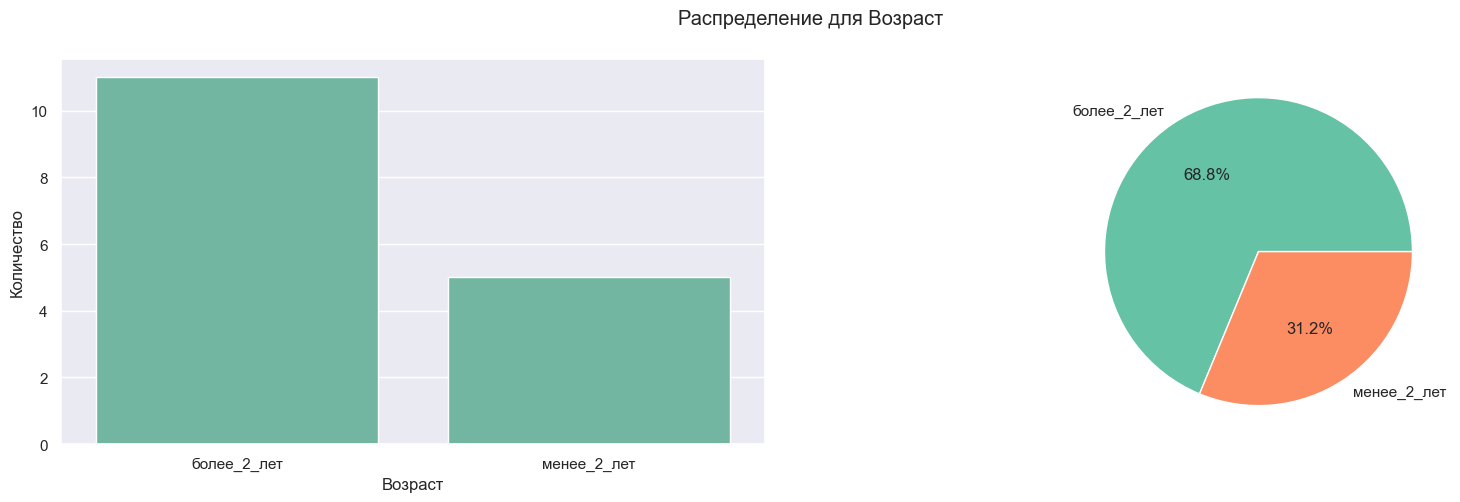

In [52]:
categorial_plot(cow_buy, 'коров, которые предназначены для покупки', 
                {'breed': 'Порода',
                 'pasture_type': 'Тип пастбища', 
                 'bull_father_breed': 'порода папы_быка', 
                 'dad_name': 'Имя Папы',
                 'age': 'Возраст'})

Для датафрейма `cow_buy`
- признаки `Порода` и `Тип пастбища` делятся пополам. Порода папы быка делится в отношении 6:4 для Соверин и Айдиал соответственно
- Соотношение имен отцов примерно такое же, как для датафрейма `dad_cows`: чаще для коров выступают отцами быки с именами Барин и Буйный, а далее идут Соловчик и Геркулес с уменьшением количества потомства от них
- Для возраста заметно превалирование коров старше двух лет: их в 2.3 раза больше, чем коров младше 2 лет

Графики количественных признаков для коров, которые предназначены для покупки


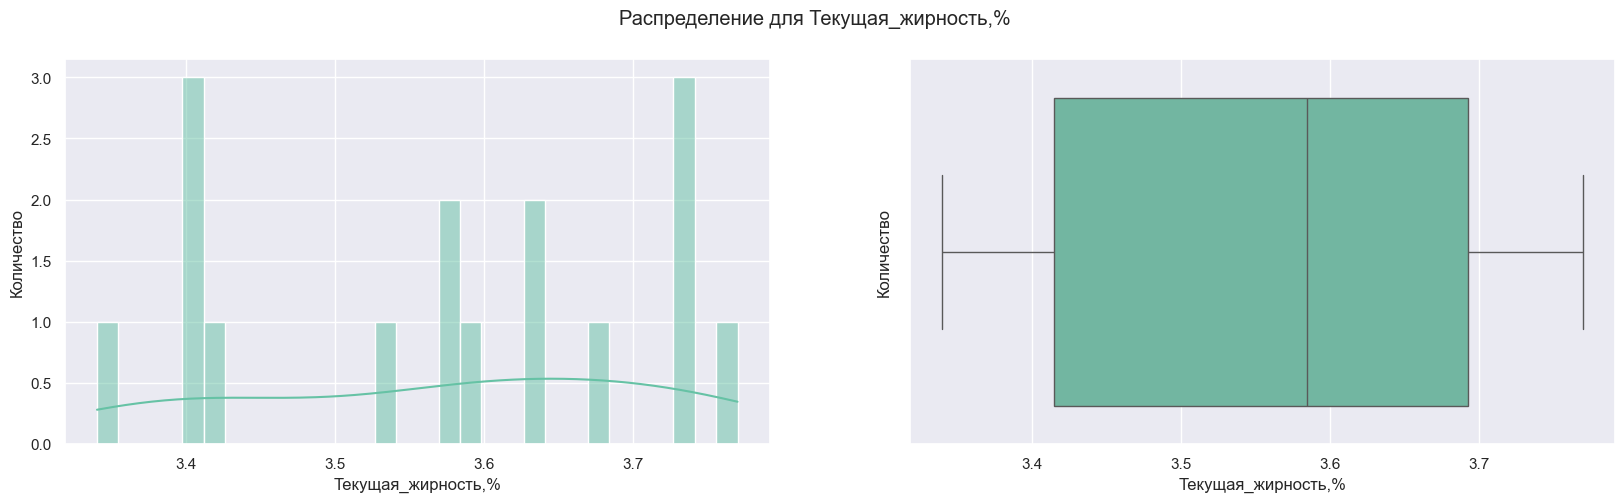

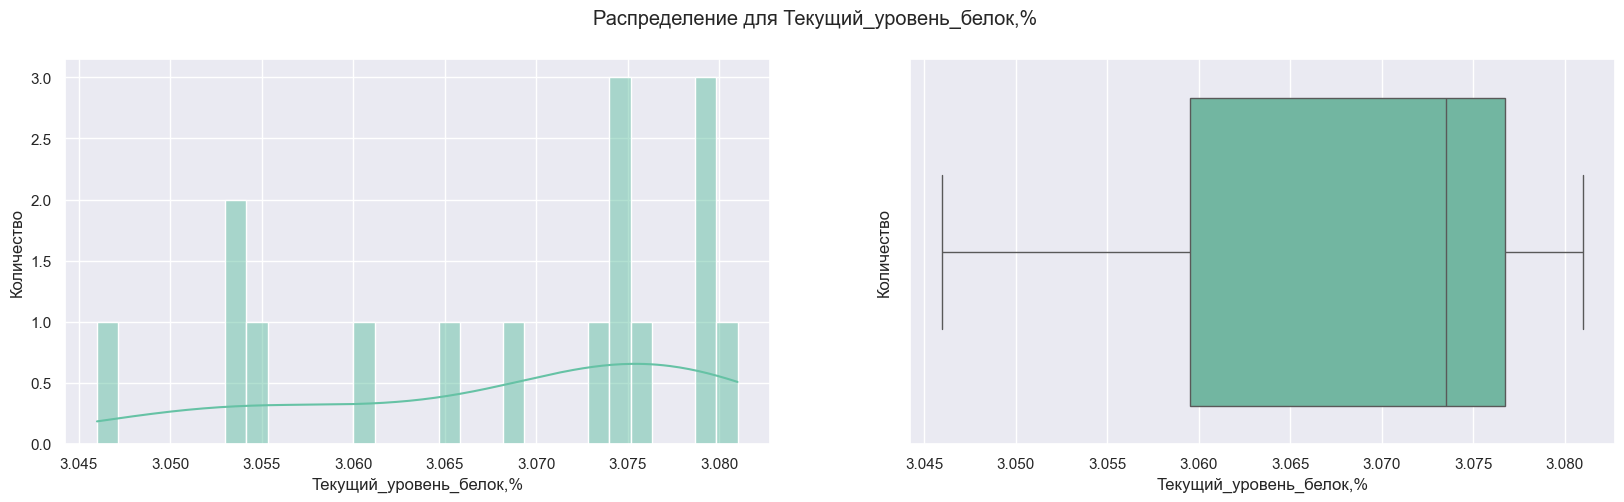

In [53]:
numerical_plot(cow_buy, 'коров, которые предназначены для покупки', 
              {'fat_content_now': 'Текущая_жирность,%',
               'protein_now': 'Текущий_уровень_белок,%'})

Для параметров текущая жирность и текущий уровень в белка отстуствуют заметные максимумы, значения распределены в больше степени равномерно в некотором диапазоне. Медианное значение 3.585000 и 3.073500 для текущей жирности и текущего уровня белка соответственно

**Вывод**:
- Для `ferma`:
    - Одним из шагов было рассмотрение количественных признаков. Для них было выяснено:
        - Для графика удоя был удален один выброс, который нельзя было интерпретировать по другому, полученное распределение нельзя назвать нормальным, самое большое количество значений находится в районе 6500 кг, а медианное значение - 6133 кг
        - Распределение ЭКЕ не является нормальным, в нем нет каких-то характерных выбросов. Его медианное значение - 14.7
        - Для СПО чаще всего значения находятся в диапазоне 1700 - 1900, медианное значение составляет 1888, выбросов на графике не наблюдается.
        - Жирность молока чаще всего составляет около 3.7 процентов, ее медианное значение составляет 3.65 процентов, из-за чего значениия с жирностью меньше 3.4 выпадают из дипазаона и являются выбросами, однако было принято решение их оставить
        - Процентное содержание белка имеет нормальное распределение, медианное значение составляет 3.076. На графике также наблюдается три выброса, однако различия составляют сотые доли и поэтому было принято решение их оставить
    - Для категориальных признаков были построены столбчатые и круговые диаграммы.
        - Порода представлена в двух видах, которые разделены в соотношении 6:4 для Вис Бик Айдиал и РефлешнСоверинг соответственно
        - Тип пастбища представлен в виде Холмистое и Равнинное в соотношении 11:9 соответственно
        - Порода отца коровы представлена в соотношении 1:1 для Айдиал и Соверин
        - Большая часть коров старше двух лет
        - Вкус молока у коровы чаще всего явлется вкусным и разделяется в соотношении 6:4 для вкусно и невкусно
- Для `dad_cows`:
    - Построив диаграмму можно отметить, что для чаще для коров выступают отцами быки с именами Барин и Буйный, а далее идут Соловчик и Геркулес с уменьшением количества потомства от них
- Для `cow_buy`:
    - Построены графики для количественных признаков:
        - Для параметров текущая жирность и текущий уровень в белка отстуствуют заметные максимумы, значения распределены в больше степени равномерно в некотором диапазоне. Медианное значение 3.585000 и 3.073500 для текущей жирности и текущего уровня белка соответственно
    - Построены столбчатые и круговые диаграммы для категориальных признаков:
        - признаки `Порода` и `Тип пастбища` делятся пополам. Порода папы быка делится в отношении 6:4 для Соверин и Айдиал соответственно
        - Соотношение имен отцов примерно такое же, как для датафрейма `dad_cows`: чаще для коров выступают отцами быки с именами Барин и Буйный, а далее идут Соловчик и Геркулес с уменьшением количества потомства от них
        - Для возраста заметно превалирование коров старше двух лет: их в 2.3 раза больше, чем коров младше 2 лет

## Корреляционный анализ

1. Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

In [54]:
ferma.corr(method='spearman', numeric_only=True)

id  yield_kg  energy_feed_unit  crude_protein_g  \
id                   1.000000 -0.003097         -0.022382        -0.037108   
yield_kg            -0.003097  1.000000          0.765144         0.437543   
energy_feed_unit    -0.022382  0.765144          1.000000         0.384747   
crude_protein_g     -0.037108  0.437543          0.384747         1.000000   
sugar_protein_ratio -0.021642  0.787904          0.741962         0.485890   
fat_content          0.038631  0.688506          0.686973         0.392822   
protein              0.003743 -0.005701         -0.013321         0.229051   

                     sugar_protein_ratio  fat_content   protein  
id                             -0.021642     0.038631  0.003743  
yield_kg                        0.787904     0.688506 -0.005701  
energy_feed_unit                0.741962     0.686973 -0.013321  
crude_protein_g                 0.485890     0.392822  0.229051  
sugar_protein_ratio             1.000000     0.701044  0.109924  
fat_content                     0.701044     1.000000  0.043125  
protein                         0.109924     0.043125  1.000000

<Axes: >

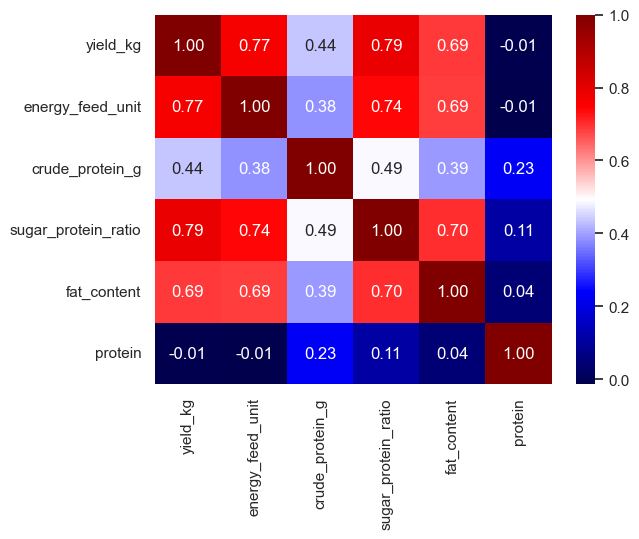

In [55]:
sns.heatmap(ferma.drop(columns='id').corr(method='spearman', 
                                          numeric_only=True), 
            annot=True, 
            cmap='seismic', 
            fmt=".2f")

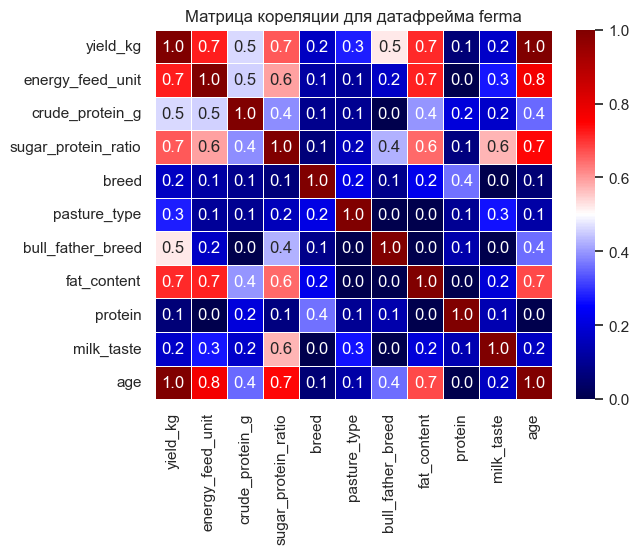

In [56]:
ax = sns.heatmap(ferma.drop(columns='id').phik_matrix(interval_cols=list(numerical_ferma.keys())), 
                 cmap='seismic', 
                 annot=True, 
                 fmt=".1f", 
                 linewidth=.5)
ax.set_title('Матрица кореляции для датафрейма ferma');

Зависимость можно наблюдать для `bull_father_breed`, `crude_protein_g`, `sugar_protein_ratio`, `energy_feed_unit`

2. Постройте диаграммы рассеяния `scatterplot` для признака `Удой, кг` и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для `Удой, кг` и `Сырой протеин, г`, цвет точек диаграммы отображает признак `Порода`. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.

In [57]:
def plot_correlation(df: pd.DataFrame, feature: str, feature_ru: str, 
                     field: str = 'yield_kg', signs: dict = categorial_ferma) -> None:
    figure, axes = plt.subplots(1, 5, figsize=(24, 4))
    plt.suptitle(f'Диаграммы рассеяния для {feature_ru}')
    for num, sign in enumerate(signs.keys()):
        sns.scatterplot(data=df, x=feature, y=field, hue=sign, ax=axes[num])
        axes[num].set_xlabel(feature_ru)
        axes[num].set_ylabel(signs[sign])
    
    fig, ax = plt.subplots(5, 1, figsize=(12, 25))
    for num, sign in enumerate(signs.keys()):
        sns.scatterplot(data=df, x=feature, y=field, hue=sign, ax=ax[num])
        ax[num].set_title(f'Диаграмма рассеяния для {feature_ru} от {signs[sign]}', fontsize=10)
        ax[num].set_xlabel(feature_ru, fontsize=9)
        ax[num].set_ylabel(signs[sign], fontsize=9)

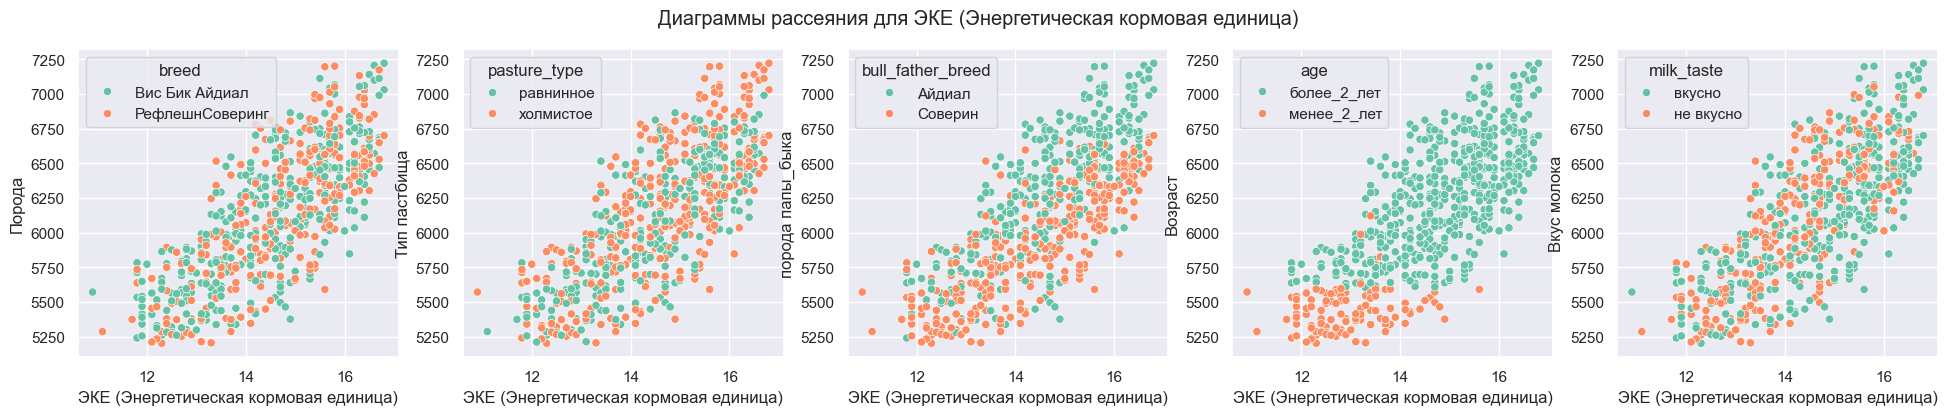

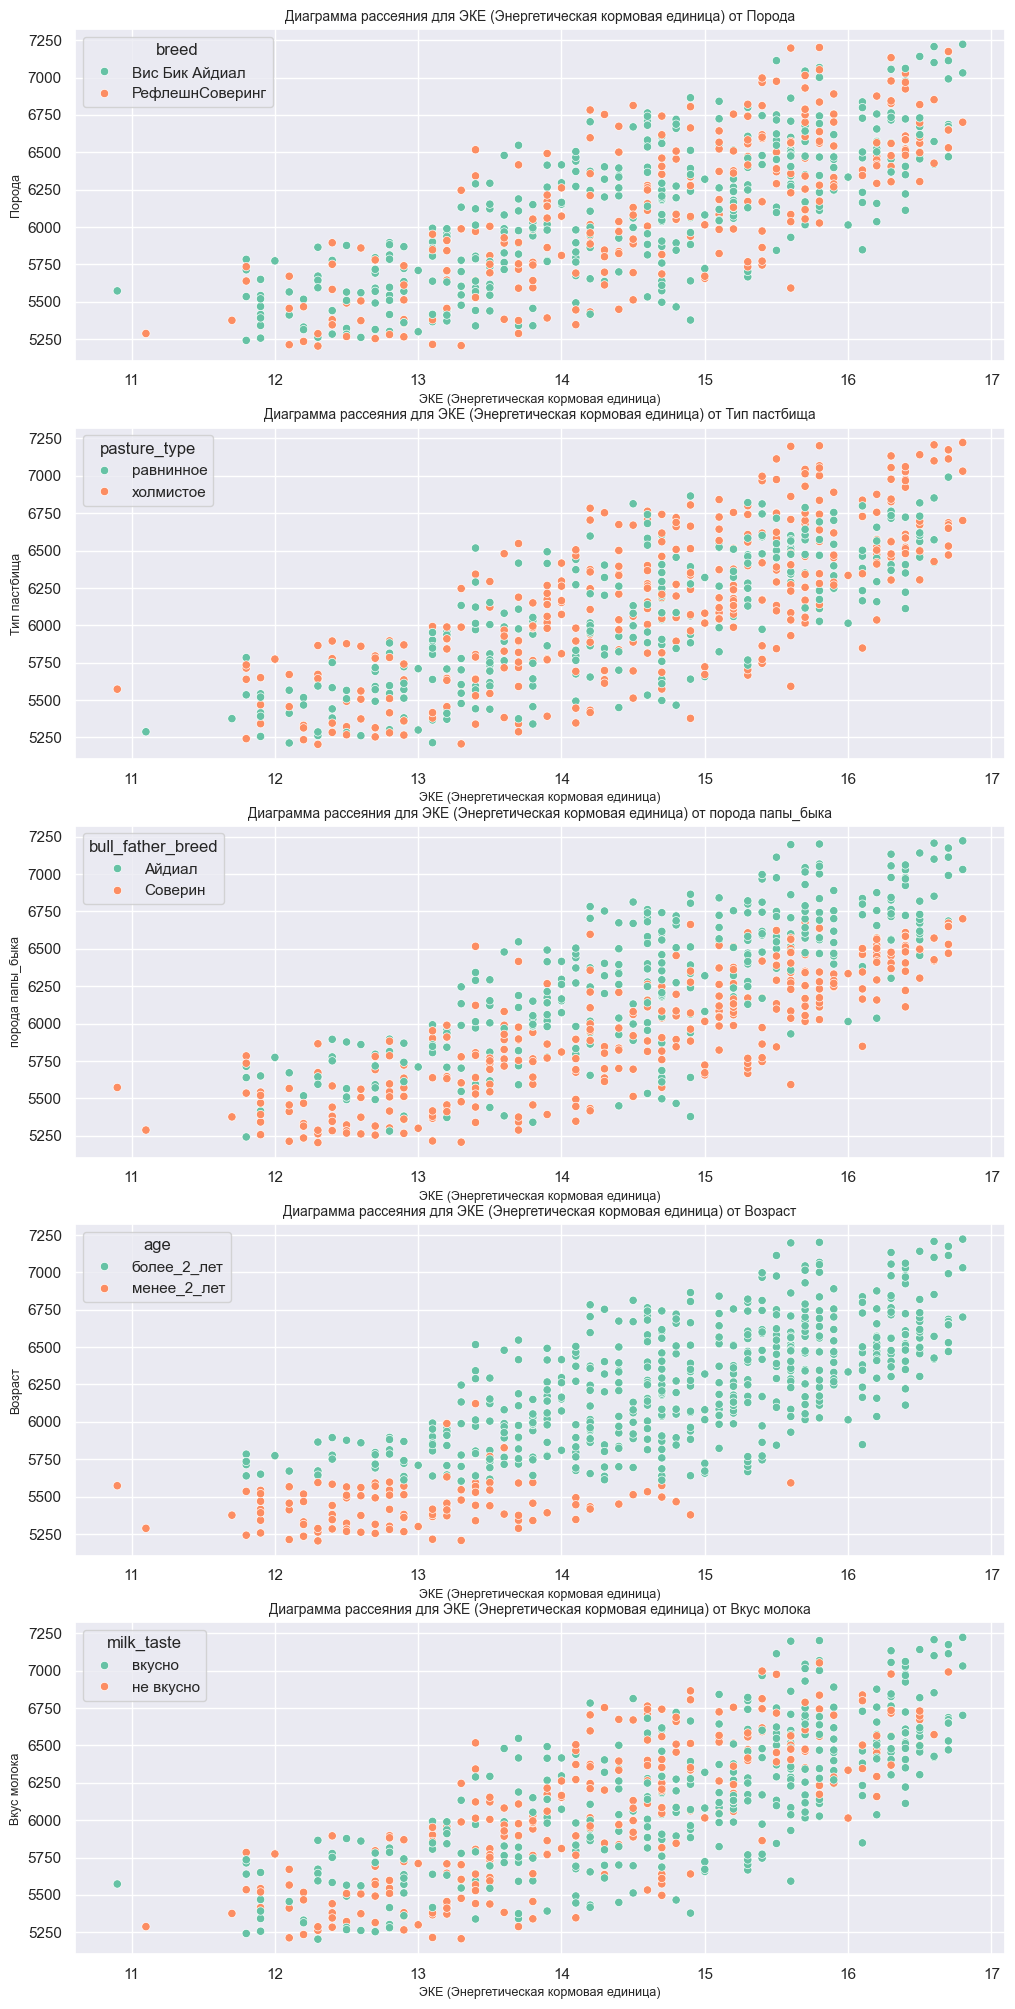

In [58]:
plot_correlation(ferma, 'energy_feed_unit', 'ЭКЕ (Энергетическая кормовая единица)')

Видна нелинейная зависимость Удоя в килограммах от энергетической кормовой единицы, так же видно влияние возраста коровы - старше двух лет она дает больше молока, а так же породы отца - при отце породы Айдиал корова дает больше молока

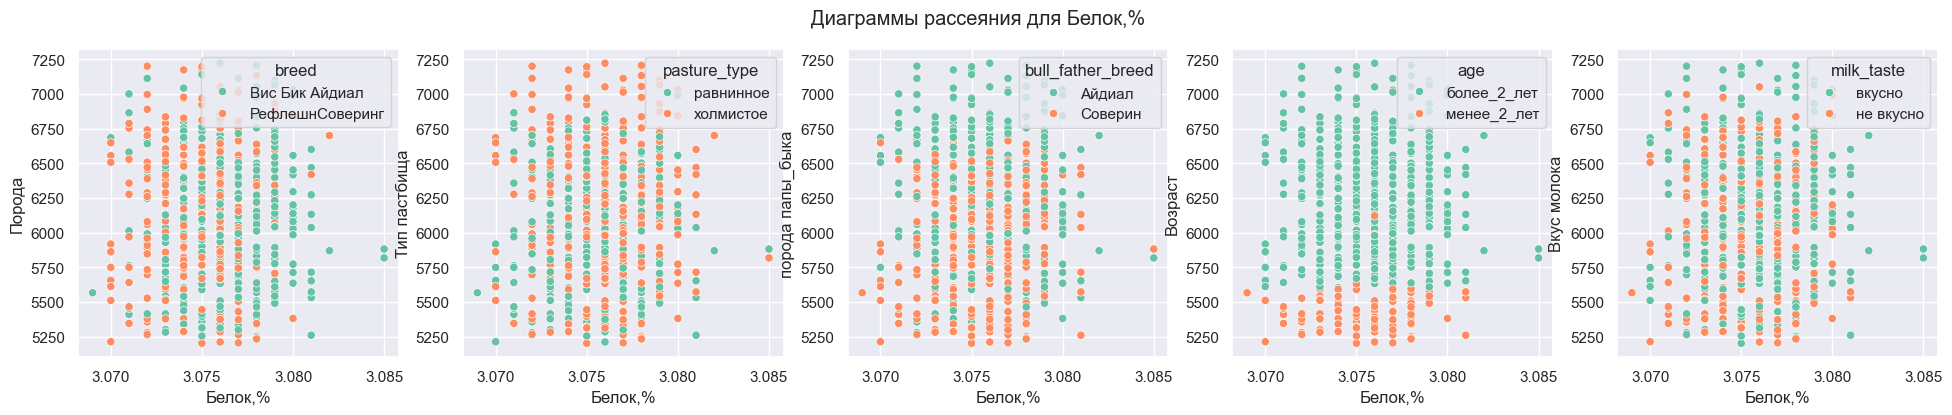

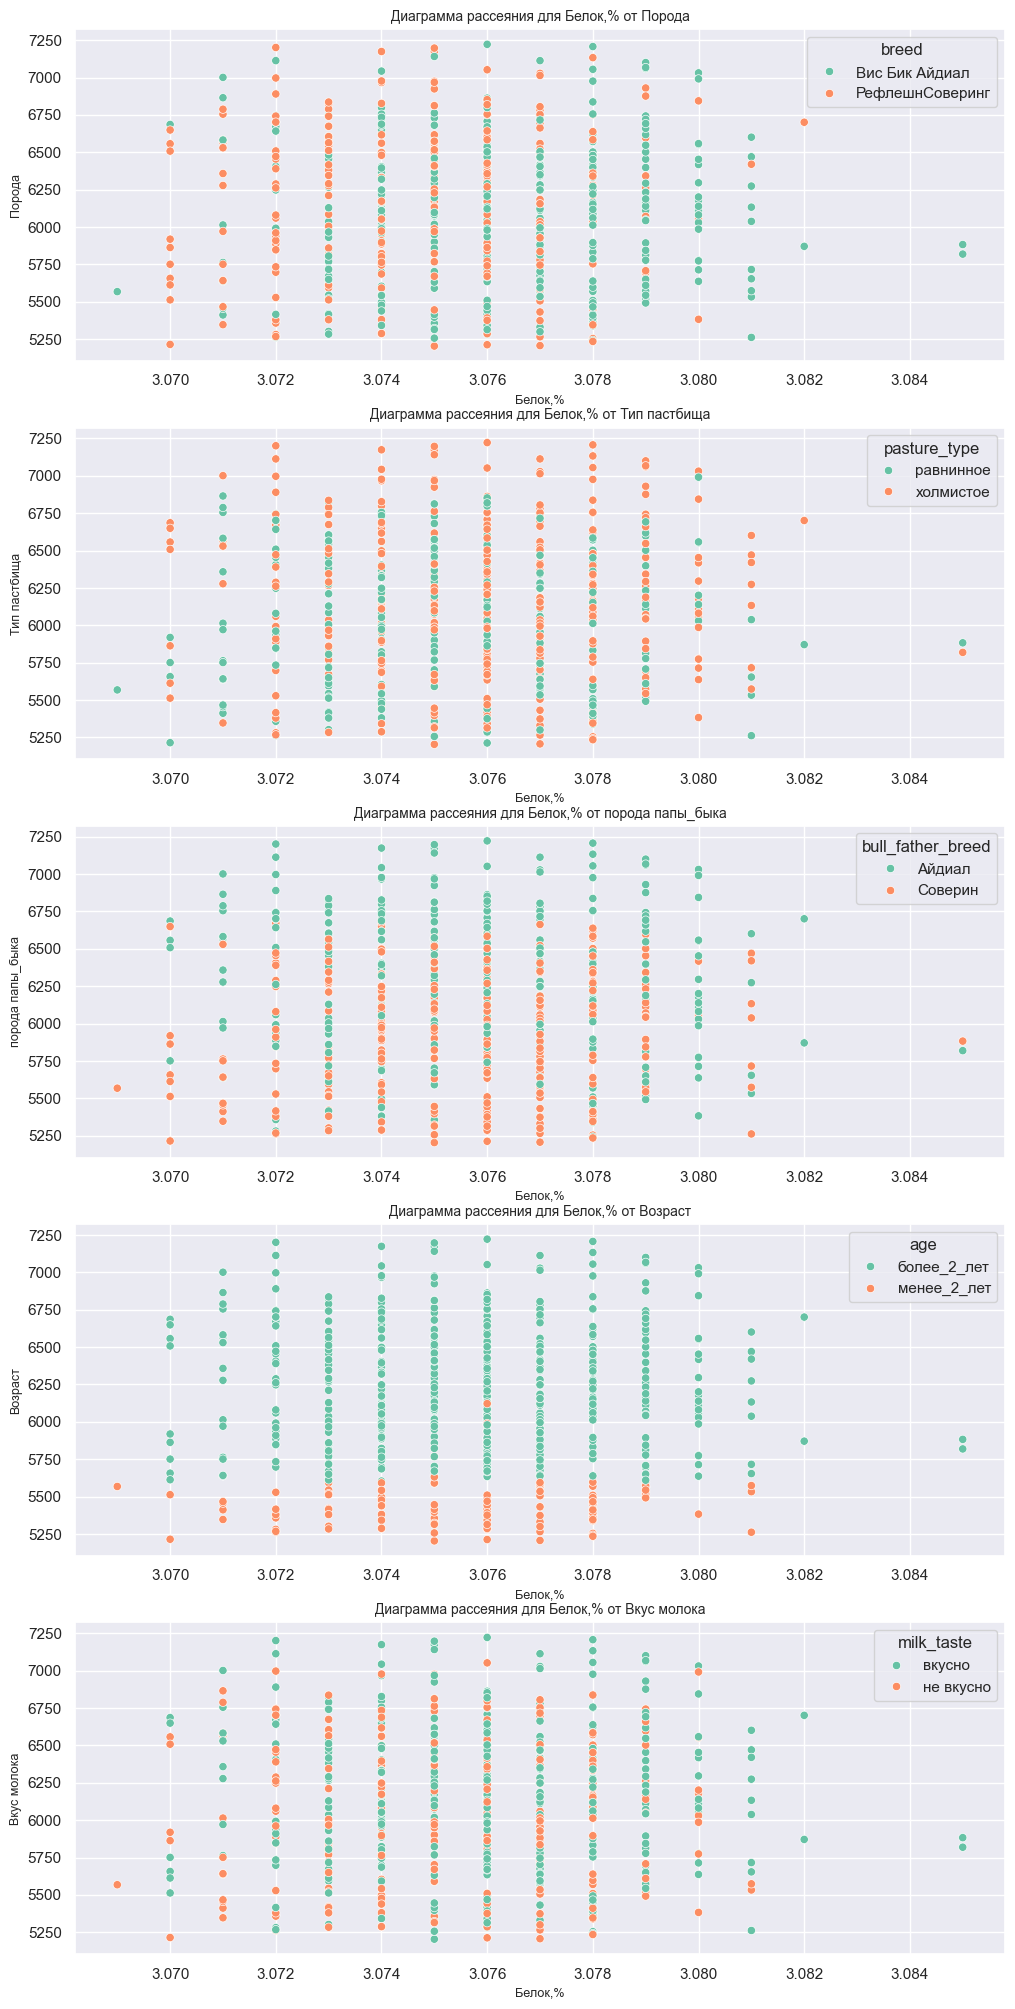

In [59]:
plot_correlation(ferma, 'protein', 'Белок,%')

При рассмотрении протеина и удоя не было обнаружено какой-то зависимости или связи между признаками.

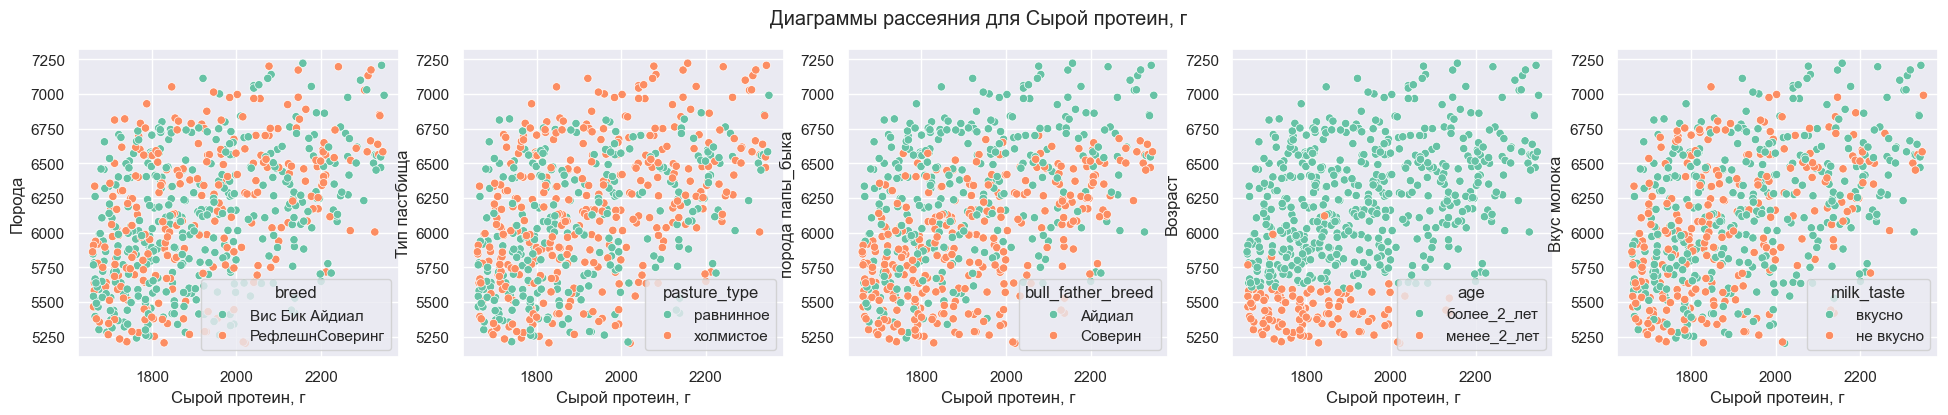

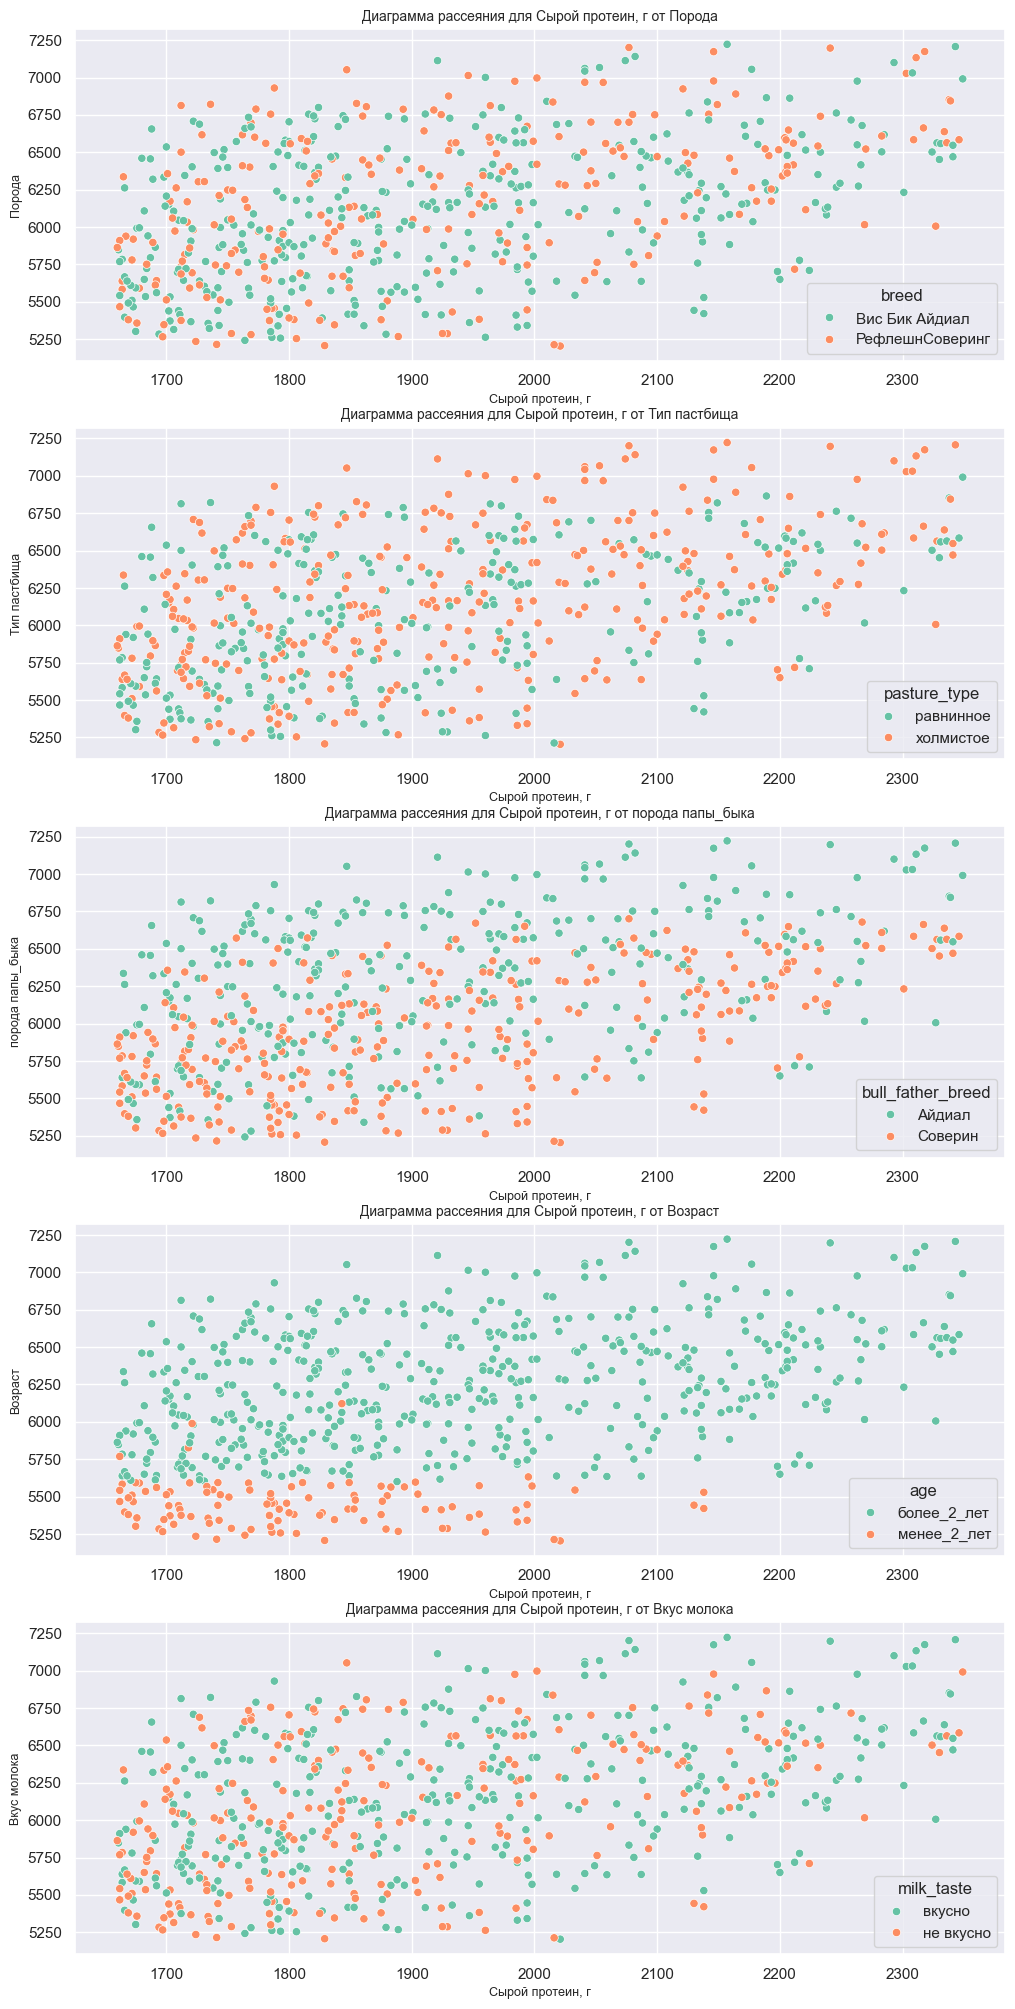

In [60]:
plot_correlation(ferma, 'crude_protein_g', 'Сырой протеин, г')

Для Сырой протеин, г заметна слабая корреляция от количества удоя в килограммах

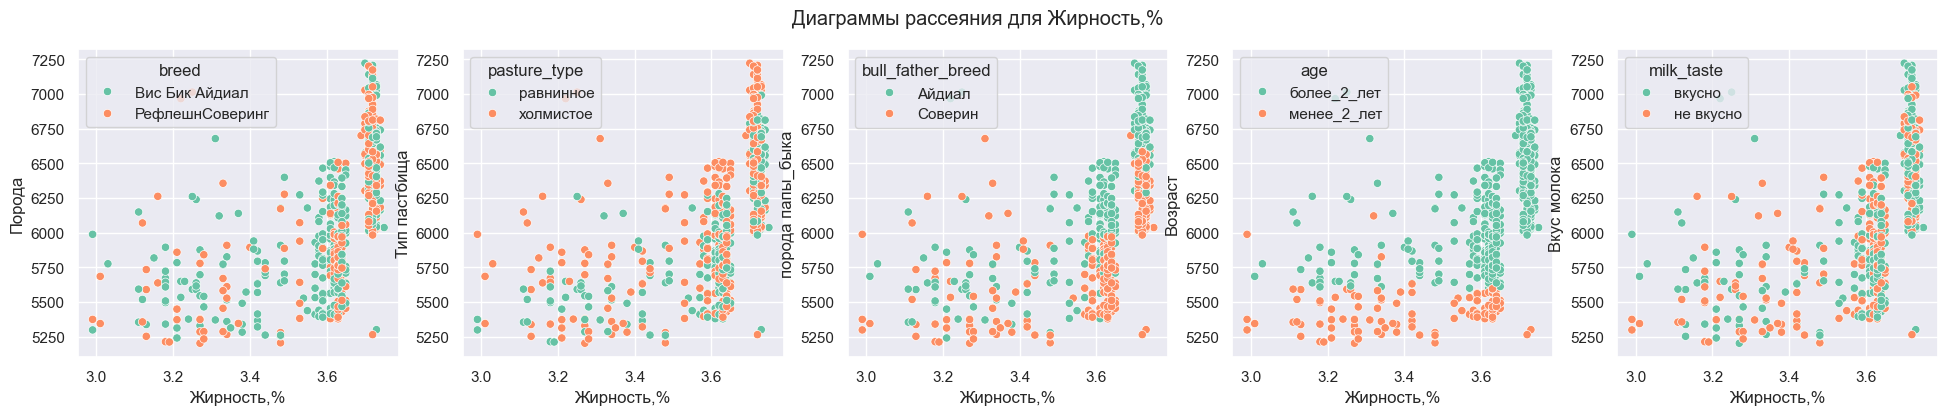

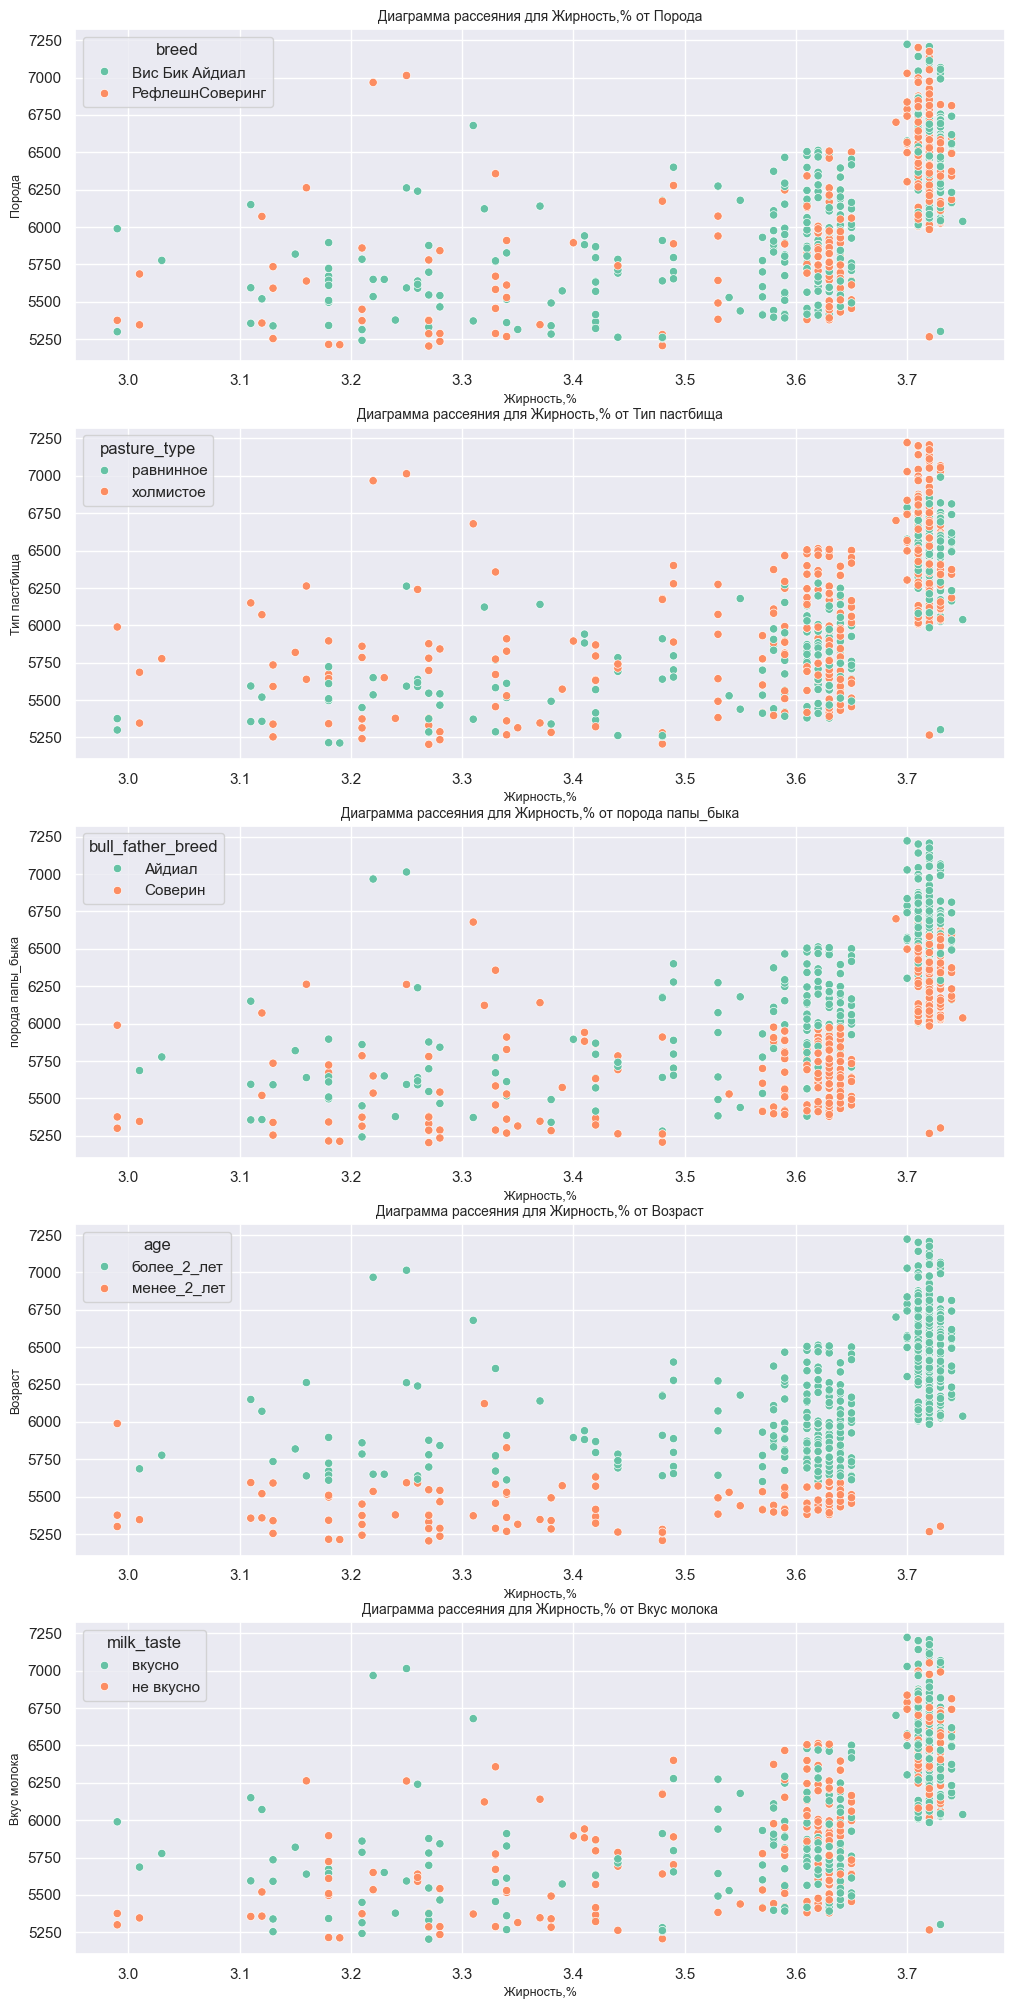

In [61]:
plot_correlation(ferma, 'fat_content', 'Жирность,%')

Заметно две группировки данных в районе 3.6 и 3.7 для Жирность,%, однако заметна определенная линейная зависимость. Так же заметно влияние категориальных признаков породы отца и возраста.

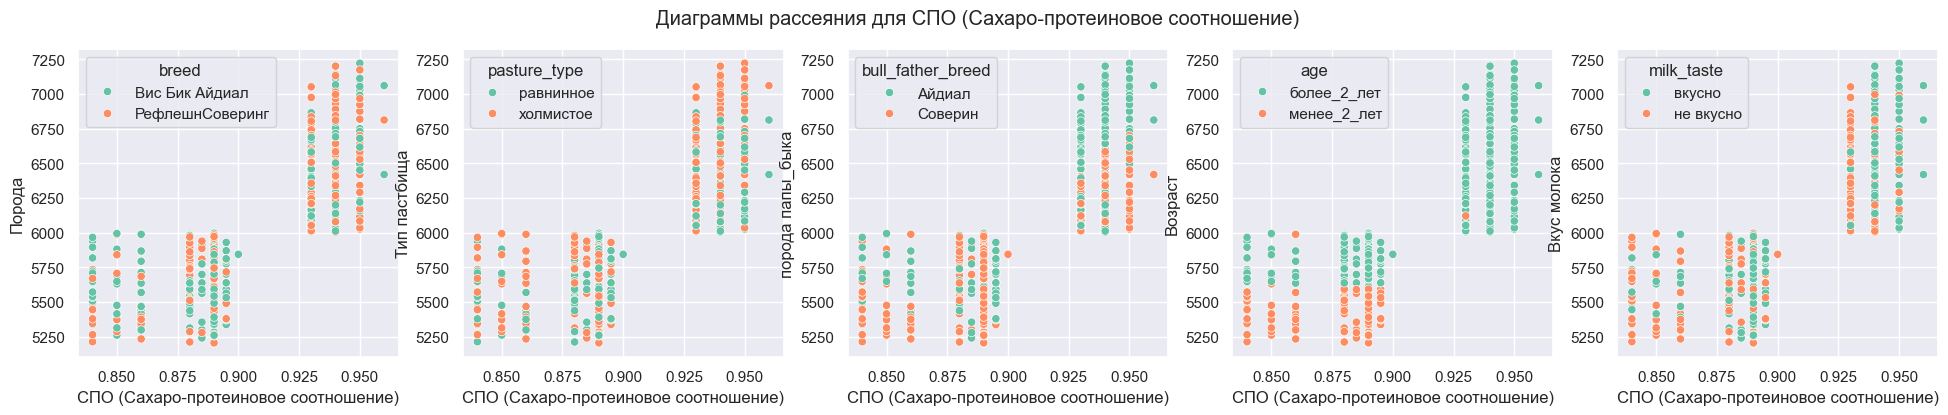

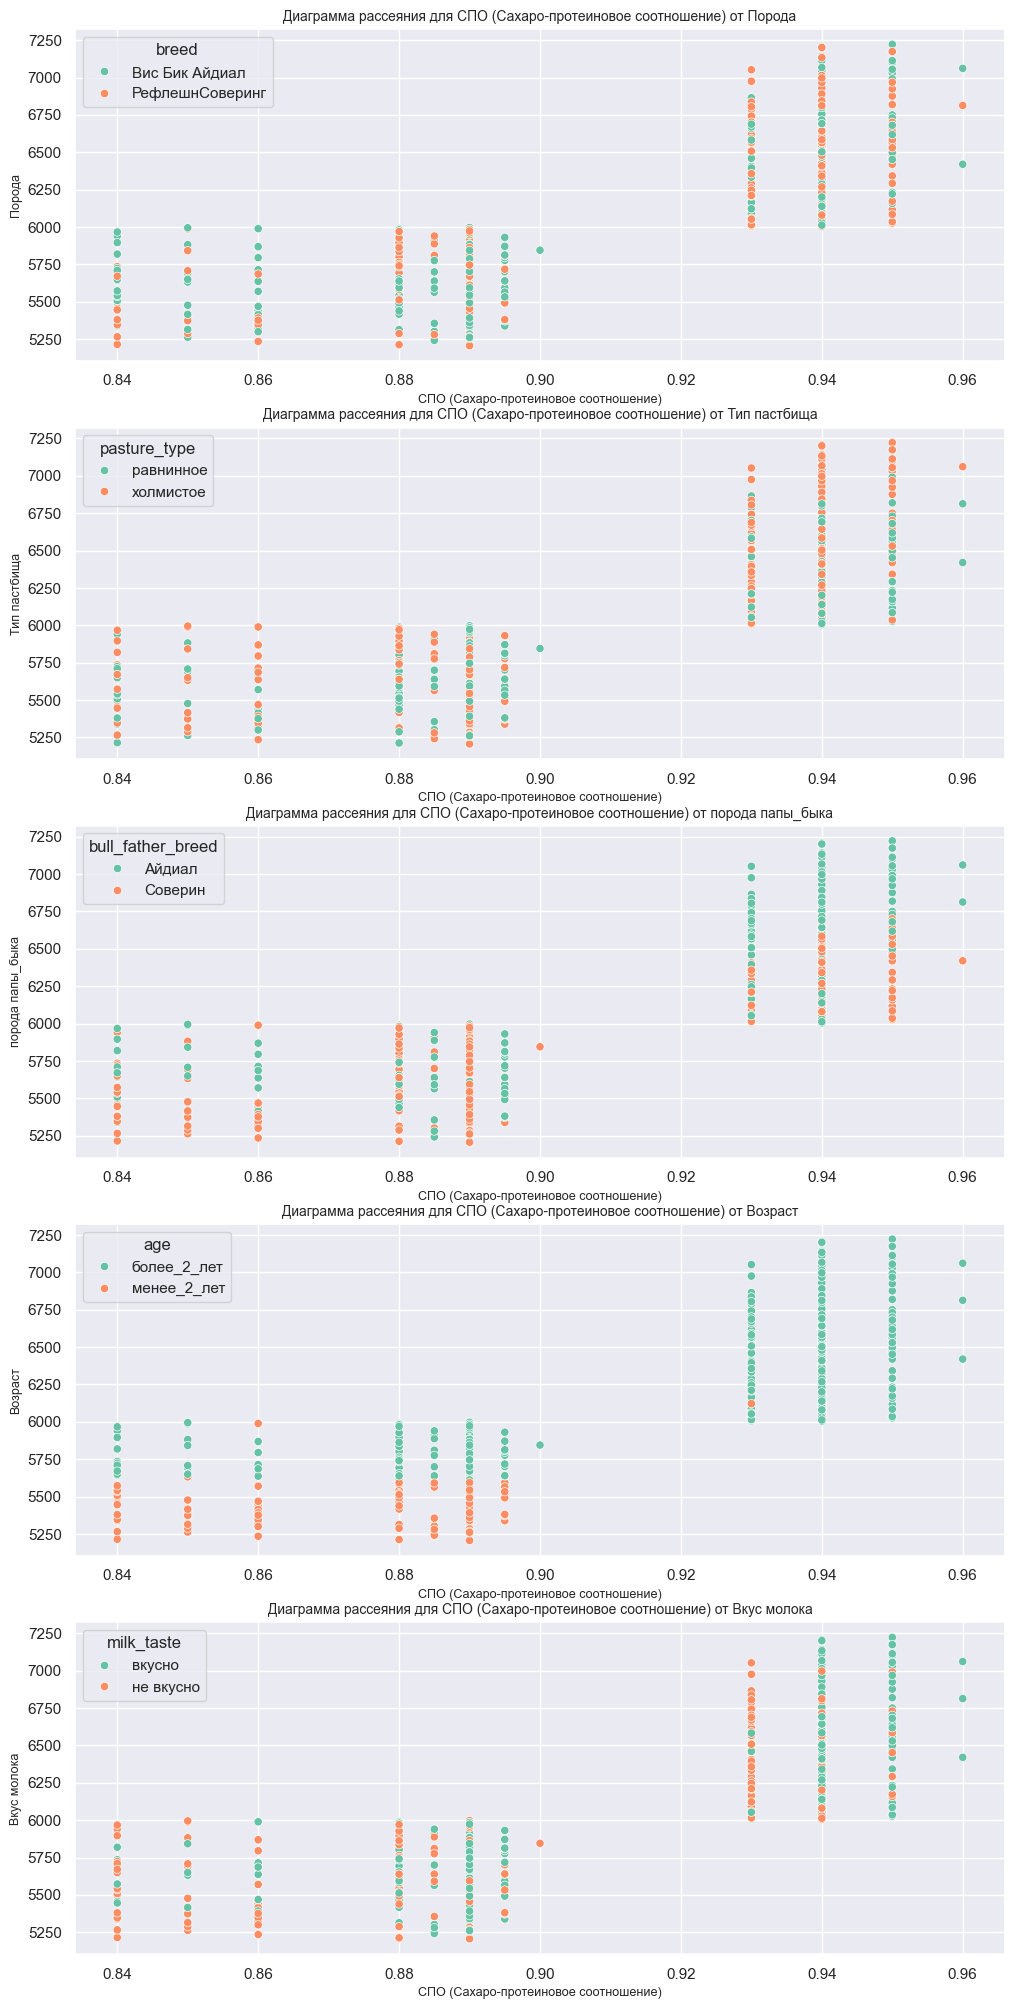

In [62]:
plot_correlation(ferma, 'sugar_protein_ratio', 'СПО (Сахаро-протеиновое соотношение)')

Для СПО заметна группировка данных в двух местах относительно границы в 0.91

3. Сделайте выводы о взаимосвязи признаков.
    - Какой тип взаимосвязи между целевым и входными признаками?
    - Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
    - Наблюдается ли мультиколлинеарность между входными признаками?

- Почти между всеми входными и целевым признаками наблюдается прямая связь, имеется нелинейная связь для признаков ЭКЕ (Энергетическая кормовая единица), СПО (Сахаро-протеиновое соотношение) и 'Жирность,%
- Для признака Белок,% не видно никакой зависимости

**Вывод**:
- Почти между всеми входными и целевым признаками наблюдается прямая связь, имеется нелинейная связь для признаков ЭКЕ (Энергетическая кормовая единица), СПО (Сахаро-протеиновое соотношение) и 'Жирность,%, так же:
    - Видна нелинейная зависимость Удоя в килограммах от энергетической кормовой единицы, так же видно влияние возраста коровы - старше двух лет она дает больше молока, а так же породы отца - при отце породы Айдиал корова дает больше молока
    - Для СПО заметна группировка данных в двух местах относительно границы в 0.91
    - Заметно две группировки данных в районе 3.6 и 3.7 для Жирность,%, однако заметна определенная линейная зависимость. Так же заметно влияние категориальных признаков породы отца и возраста.
- Для признака Белок,% не видно никакой зависимости
- Для Сырой протеин, г заметна слабая корреляция от количества удоя в килограммах
- Между признаками не наблюдается мультиколлинеарности

## Обучение модели линейной регрессии

**Вам предстоит обучить три модели простой линейной регрессии.**

1. Подготовьте данные датасета `ferma_main.csv` и обучите на них первую модель `LinearRegression`.
    - Используйте в качестве целевого признак `Удой, кг`.
    - Отберите признаки, которые подходят для модели линейной регрессии, аргументируйте выбор. Опирайтесь не только на наличие или отсутствие линейной связи между признаками, но и на причинно-следственные связи между удоем коров и группами признаков из описания датасета.
    - Разбейте данные на тренировочную и тестовую выборки.
    - Кодируйте категориальные признаки с помощью `OneHotEncoder`.
    - Масштабируйте количественные признаки с помощью `StandardScaler`.
    - Обучите модель линейной регрессии на подготовленных данных.
    - Оцените качество модели на тестовой выборке: рассчитайте R², проанализируйте остатки с помощью графиков.
    - Оформите выводы, укажите:
        - значение R² модели;
        - какие выводы следуют из анализа остатков;
        - нужны ли дополнительные исследования.

Для дальнейшего анализа моделей создадим словарь в котором будем записывать необходимые параметры модели, а также метрики для анализа моделей, a также список параметров, которые мы хотим сохранить для каждй модели.

Чтобы сократить количество кода, напишем функцию, которая будет принимать необходимые параметры на вход и сохранять их в словарь

In [63]:
models = {}

def get_params(model, scaler, encoder, predictions, r2, mse, rmse, mae, residues, name, dictionary = models):
    dictionary[name] = {
        'model': model,
        'scaler': scaler,
        'encoder': encoder,
        'predictions': predictions,
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'residues': residues
    }

In [64]:
ferma.head()

id  yield_kg  energy_feed_unit  crude_protein_g  sugar_protein_ratio  \
0   1      5863              14.2             1743                0.890   
1   2      5529              12.8             2138                0.890   
2   3      5810              14.0             1854                0.885   
3   4      5895              12.4             2012                0.885   
4   5      5302              12.8             1675                0.885   

             breed pasture_type bull_father_breed  fat_content  protein  \
0   Вис Бик Айдиал    равнинное            Айдиал         3.58    3.076   
1   Вис Бик Айдиал    равнинное           Соверин         3.54    3.079   
2  РефлешнСоверинг    холмистое           Соверин         3.59    3.074   
3  РефлешнСоверинг    холмистое            Айдиал         3.40    3.075   
4   Вис Бик Айдиал    равнинное           Соверин         3.73    3.073   

  milk_taste          age  
0     вкусно  более_2_лет  
1     вкусно  менее_2_лет  
2  не вкусно  более_2_лет  
3  не вкусно  более_2_лет  
4     вкусно  менее_2_лет

In [65]:
RANDOM_STATE = 42

In [66]:
X = ferma.drop(['yield_kg', 'milk_taste', 'id', 'protein', 'fat_content'], axis=1)
y = ferma['yield_kg']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [68]:
encoder_first = OneHotEncoder(drop='first', sparse_output=False)

In [69]:
categorial_feature = {'breed': 'Порода', 
                     'pasture_type': 'Тип пастбища', 
                     'bull_father_breed': 'порода папы_быка',
                     'age': 'Возраст'}

In [70]:
ohe_train = pd.DataFrame(encoder_first.fit_transform(X_train[categorial_feature.keys()]), 
                         columns=encoder_first.get_feature_names_out())
ohe_train.head()

breed_РефлешнСоверинг  pasture_type_холмистое  bull_father_breed_Соверин  \
0                    1.0                     1.0                        1.0   
1                    1.0                     1.0                        1.0   
2                    0.0                     0.0                        0.0   
3                    0.0                     1.0                        0.0   
4                    0.0                     0.0                        0.0   

   age_менее_2_лет  
0              0.0  
1              1.0  
2              0.0  
3              0.0  
4              0.0

In [71]:
ohe_test = pd.DataFrame(encoder_first.transform(X_test[categorial_feature.keys()]),
                        columns=encoder_first.get_feature_names_out())
ohe_test.head()

breed_РефлешнСоверинг  pasture_type_холмистое  bull_father_breed_Соверин  \
0                    0.0                     1.0                        0.0   
1                    1.0                     1.0                        1.0   
2                    1.0                     1.0                        1.0   
3                    0.0                     0.0                        1.0   
4                    0.0                     1.0                        1.0   

   age_менее_2_лет  
0              0.0  
1              0.0  
2              1.0  
3              0.0  
4              0.0

In [72]:
scaler_first = StandardScaler()

In [73]:
numerical_feature = {'energy_feed_unit': 'ЭКЕ (Энергетическая кормовая единица)',
                    'crude_protein_g': 'Сырой протеин, г',
                    'sugar_protein_ratio': 'СПО (Сахаро-протеиновое соотношение)'}

In [74]:
scale_train = pd.DataFrame(scaler_first.fit_transform(X_train[numerical_feature.keys()]),
                           columns=numerical_feature.keys())
scale_train.head()

energy_feed_unit  crude_protein_g  sugar_protein_ratio
0          1.502378         1.079523             0.837130
1         -1.557270        -0.196920            -0.703660
2          0.125537        -1.386085            -1.011818
3         -0.103937         0.752230             0.837130
4         -1.098323         0.828598            -0.703660

In [75]:
scale_test = pd.DataFrame(scaler_first.transform(X_test[numerical_feature.keys()]),
                          columns=numerical_feature.keys())
scale_test.head()

energy_feed_unit  crude_protein_g  sugar_protein_ratio
0         -0.486393        -0.813322            -1.011818
1          1.425887         0.026730             0.837130
2         -0.486393        -0.682405            -1.628134
3         -0.945340        -1.058792            -1.011818
4          0.584484        -1.413360            -0.703660

In [76]:
X_train = pd.concat([ohe_train, scale_train], axis=1)
X_test = pd.concat([ohe_test, scale_test], axis=1)

In [77]:
model_lr_first = LinearRegression()

In [78]:
model_lr_first.fit(X_train, y_train)

LinearRegression()

In [79]:
predictions_first = model_lr_first.predict(X_test)

In [80]:
r2_first = r2_score(y_test, predictions_first)
round(r2_first, 2)

0.78

In [81]:
residues_first = y_test - predictions_first

In [82]:
def plot_residues(residues: pd.Series, predictions: np.ndarray) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    axes[0].hist(residues)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residues)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии');

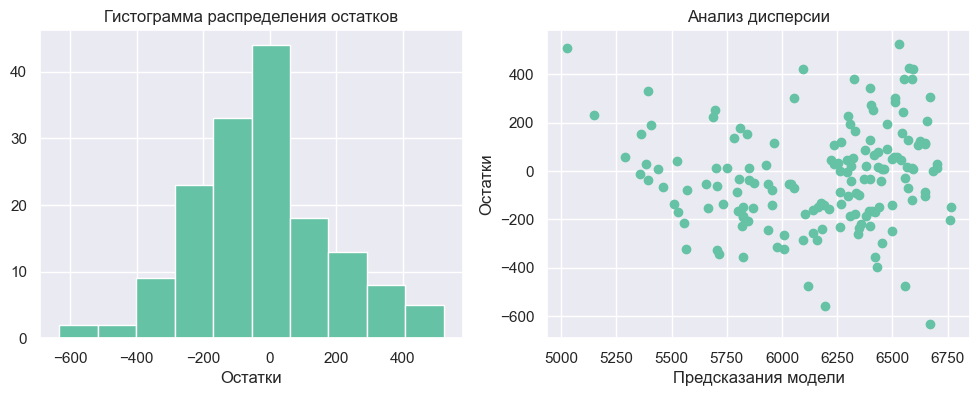

In [83]:
plot_residues(residues_first, predictions_first)

In [84]:
mse_first = mean_squared_error(y_test, predictions_first)
rmse_first = mean_squared_error(y_test, predictions_first, squared=False)
mae_first = mean_absolute_error(y_test, predictions_first)

In [85]:
get_params(model_lr_first, scaler_first, encoder_first, predictions_first, r2_first, 
           mse_first, rmse_first, mae_first, residues_first, 'first')

**На основании обучения можно сделать вывод:**
- R² = 0.78, данное значение довольно близко к единице, поэтому модель предсказывает довольно точно, однако есть простор для улучшения модели
- Из распределения остатков можно сделать вывод, что оно имеет смещенное нормальное распределение, что говорит о том, что большую часть значений модель предсказала верно
- На графике диспресии заметно, что происходит чередование низкой и высокой диспресии остатков. Это говорит о том, что необходимо пересмотреть признаки и провести еще анализ

**2. Подготовьте данные с учётом связи входных признаков с целевым и обучите на них вторую модель `LinearRegression`.**
- Посмотрите на диаграммы рассеяния: на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно. Исключите нелинейность, чтобы эти признаки были информативны для линейной регрессии. Вот несколько способов, которыми это можно сделать:
- Вы обнаружите, что `СПО` и `Удой` связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение `СПО`, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуйте `СПО` в категориальный бинарный признак, использовав эту границу.
- Вы обнаружите, что `ЭКЕ` и `Удой` также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак `ЭКЕ в квадрате`.
- Повторите шаги из пункта 1 и создайте вторую модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.

Проведем анализ признаков и введем бинаризированное СПО и возведенное в квадрат ЭКЕ

In [86]:
def plot_scattering(df: pd.DataFrame, features: dict = {'energy_feed_unit': 'ЭКЕ (Энергетическая кормовая единица)',
                                                        'sugar_protein_ratio': 'СПО (Сахаро-протеиновое соотношение)',
                                                        'fat_content': 'Жирность,%',
                                                        'protein': 'Белок,%',
                                                        'crude_protein_g': 'Сырой протеин, г'}, 
 
                    field: str = 'yield_kg') -> None:

    figure, axes = plt.subplots(1, 5, figsize=(24, 4))
    plt.suptitle(f'Диаграммы рассеяния для Удоя')
    for num, feature in enumerate(features.keys()):
        sns.regplot(data=df, x=feature, y=field, ax=axes[num], lowess=True, line_kws=dict(color="r"), ci=99, marker=".")
        axes[num].set_ylabel('Удой, кг')
        axes[num].set_xlabel(features[feature])

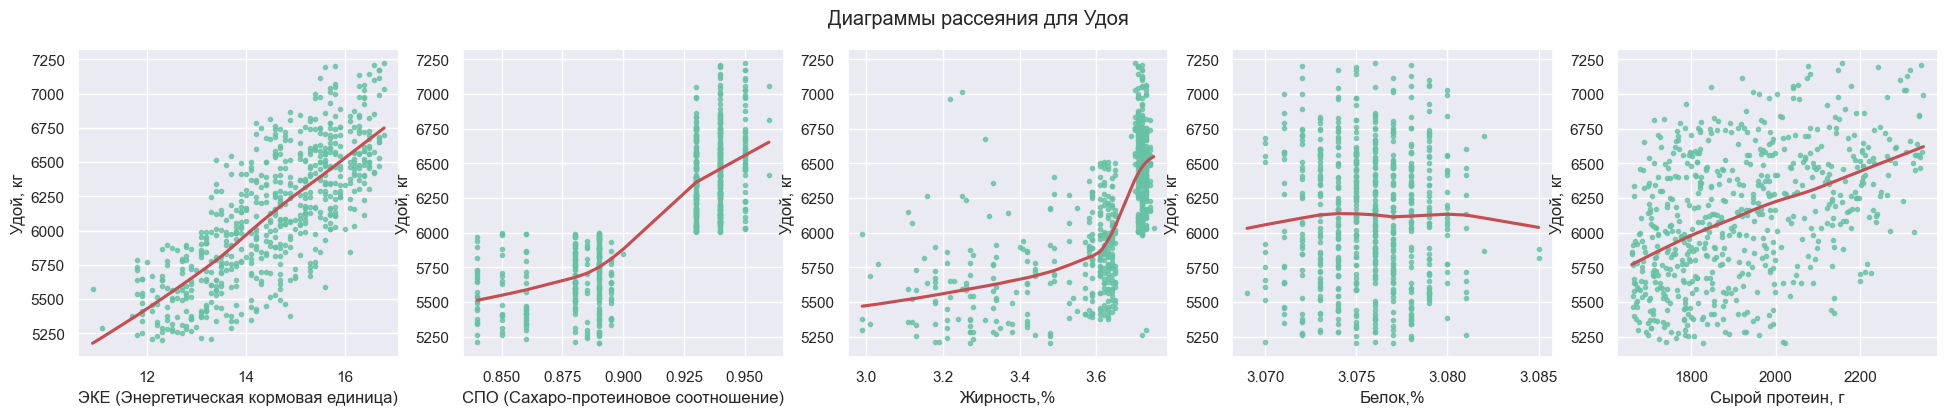

In [87]:
plot_scattering(ferma)

In [88]:
ferma['spr_bin'] = ferma['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)

In [89]:
ferma['spr_bin'].unique()

array([0, 1], dtype=int64)

In [90]:
ferma['efu_squared'] = ferma['energy_feed_unit'] ** 2

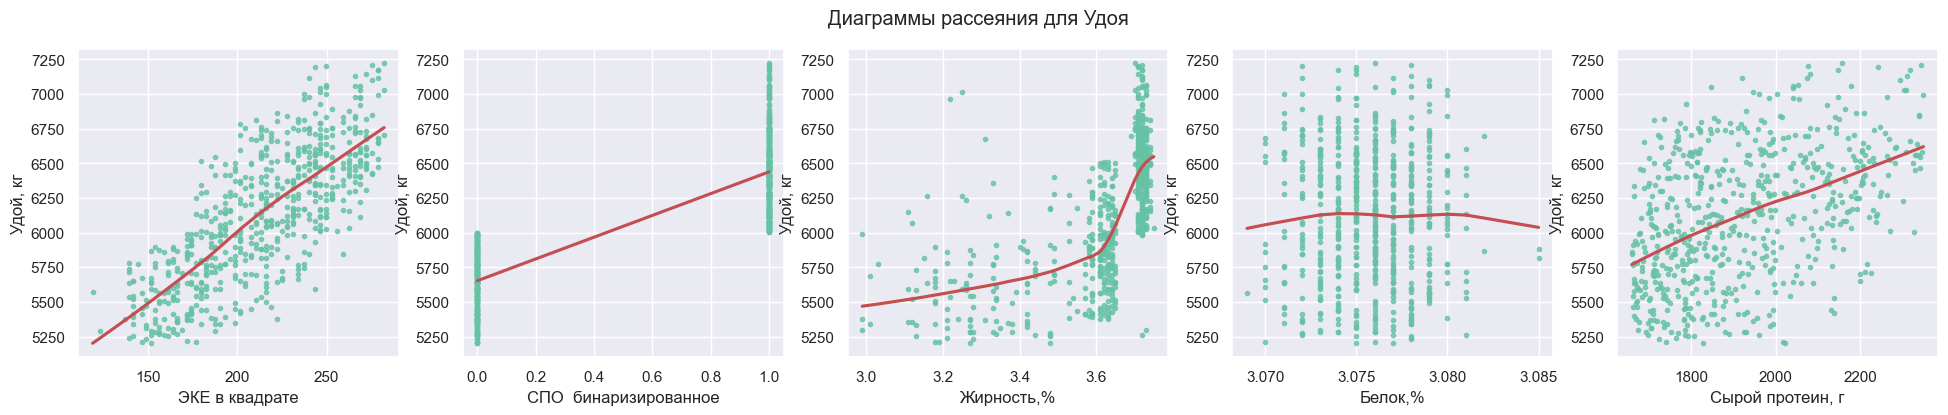

In [91]:
plot_scattering(ferma, {'efu_squared': 'ЭКЕ в квадрате',
                        'spr_bin': 'СПО  бинаризированное',
                        'fat_content': 'Жирность,%',
                        'protein': 'Белок,%',
                        'crude_protein_g': 'Сырой протеин, г'})

In [92]:
X = ferma.drop(['yield_kg', 'milk_taste', 'id', 'protein', 'fat_content'], axis=1)
y = ferma['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [93]:
X.head()

energy_feed_unit  crude_protein_g  sugar_protein_ratio            breed  \
0              14.2             1743                0.890   Вис Бик Айдиал   
1              12.8             2138                0.890   Вис Бик Айдиал   
2              14.0             1854                0.885  РефлешнСоверинг   
3              12.4             2012                0.885  РефлешнСоверинг   
4              12.8             1675                0.885   Вис Бик Айдиал   

  pasture_type bull_father_breed          age  spr_bin  efu_squared  
0    равнинное            Айдиал  более_2_лет        0       201.64  
1    равнинное           Соверин  менее_2_лет        0       163.84  
2    холмистое           Соверин  более_2_лет        0       196.00  
3    холмистое            Айдиал  более_2_лет        0       153.76  
4    равнинное           Соверин  менее_2_лет        0       163.84

In [94]:
categorial_feature =  {'breed': 'Порода', 
                     'pasture_type': 'Тип пастбища', 
                     'bull_father_breed': 'порода папы_быка',
                     'age': 'Возраст',
                     'spr_bin': 'Бинаризированное спо'}

In [95]:
encoder_second = OneHotEncoder(drop='first', sparse_output=False)

ohe_train = pd.DataFrame(encoder_second.fit_transform(X_train[categorial_feature.keys()]), 
                         columns=encoder_second.get_feature_names_out())
ohe_test = pd.DataFrame(encoder_second.transform(X_test[categorial_feature.keys()]),
                        columns=encoder_second.get_feature_names_out())

In [96]:
numerical_feature = {'energy_feed_unit': 'ЭКЕ (Энергетическая кормовая единица)',
                    'crude_protein_g': 'Сырой протеин, г',
                    'sugar_protein_ratio': 'СПО (Сахаро-протеиновое соотношение)',
                    'efu_squared': 'Возведенное в квадрат ЭКЕ'}

In [97]:
scaler_second = StandardScaler()

scale_train = pd.DataFrame(scaler_second.fit_transform(X_train[numerical_feature.keys()]),
                          columns=numerical_feature.keys())
scale_test = pd.DataFrame(scaler_second.transform(X_test[numerical_feature.keys()]),
                          columns=numerical_feature.keys())

In [98]:
X_train = pd.concat([ohe_train, scale_train], axis=1)
X_test = pd.concat([ohe_test, scale_test], axis=1)

In [99]:
model_lr_second = LinearRegression()
model_lr_second.fit(X_train, y_train)
predictions_second = model_lr_second.predict(X_test)

r2_second = r2_score(y_test, predictions_second)
round(r2_second, 2)

0.82

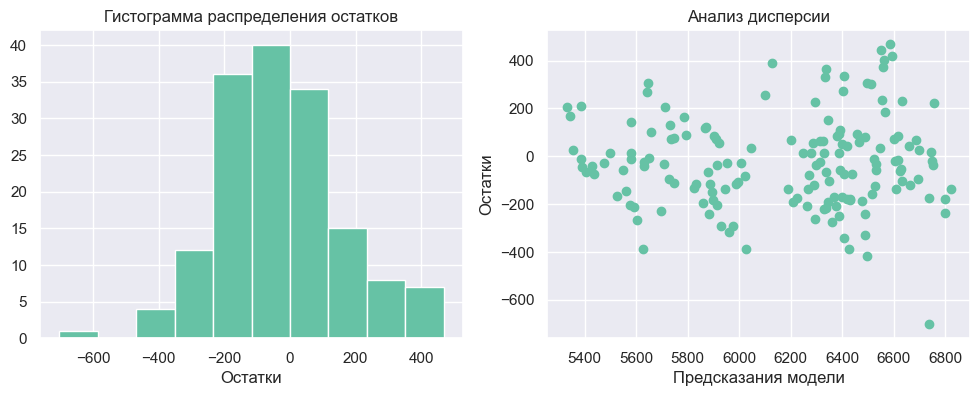

In [100]:
residues_second = y_test - predictions_second

plot_residues(residues_second, predictions_second)

In [101]:
mse_second = mean_squared_error(y_test, predictions_second)
rmse_second = mean_squared_error(y_test, predictions_second, squared=False)
mae_second = mean_absolute_error(y_test, predictions_second)

In [102]:
get_params(model_lr_second, scaler_second, encoder_second, predictions_second, r2_second, 
           mse_second, rmse_second, mae_second, residues_second, 'second')

**На основании обучения можно сделать вывод:**
- R² = 0.81, данное значение довольно близко к единице, поэтому модель предсказывает довольно точно, однако есть простор для улучшения модели
- Из распределения остатков можно сделать вывод, что оно имеет смещенное нормальное распределение, что говорит о том, что большую часть значений модель предсказала верно
- На графике диспресии представлена почти нормальная дисперсия остатков

**3. Добавьте в данные новый признак и обучите на них третью модель `LinearRegression`.**

- Добавьте признак `Имя Папы` из файла `ferma_dad.csv`, соединив его с остальными данными `ferma_main.csv` по ключу.
- Устраните нелинейность между признаками.
- Повторите шаги из пункта 1 и создайте третью модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.

In [103]:
ferma_with_dads = ferma.merge(dad_cows, on='id')

In [104]:
X = ferma_with_dads.drop(['id', 'yield_kg', 'milk_taste', 'protein', 'energy_feed_unit', 'sugar_protein_ratio', 'fat_content', 'bull_father_breed'], axis=1)
y = ferma['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [105]:
categorial_feature =  {'breed': 'Порода', 
                     'pasture_type': 'Тип пастбища',
                     'age': 'Возраст',
                     'spr_bin': 'Бинаризированное спо',
                     'dad_name': 'Имя отца'}

In [106]:
encoder_third = OneHotEncoder(drop='first', sparse_output=False)

ohe_train = pd.DataFrame(encoder_third.fit_transform(X_train[categorial_feature.keys()]), 
                         columns=encoder_third.get_feature_names_out())
ohe_test = pd.DataFrame(encoder_third.transform(X_test[categorial_feature.keys()]),
                        columns=encoder_third.get_feature_names_out())

In [107]:
numerical_feature = {'crude_protein_g': 'Сырой протеин, г',
                    'efu_squared': 'Возведенное в квадрат ЭКЕ'}

In [108]:
scaler_third = StandardScaler()

scale_train = pd.DataFrame(scaler_third.fit_transform(X_train[numerical_feature.keys()]),
                         columns=numerical_feature.keys())
scale_test = pd.DataFrame(scaler_third.transform(X_test[numerical_feature.keys()]),
                         columns=numerical_feature.keys())

In [109]:
X_train = pd.concat([ohe_train, scale_train], axis=1)
X_test = pd.concat([ohe_test, scale_test], axis=1)

In [110]:
model_lr_third = LinearRegression()
model_lr_third.fit(X_train, y_train)

predictions_third = model_lr_third.predict(X_test)
r2_third = r2_score(y_test, predictions_third)
round(r2_third, 2)

0.83

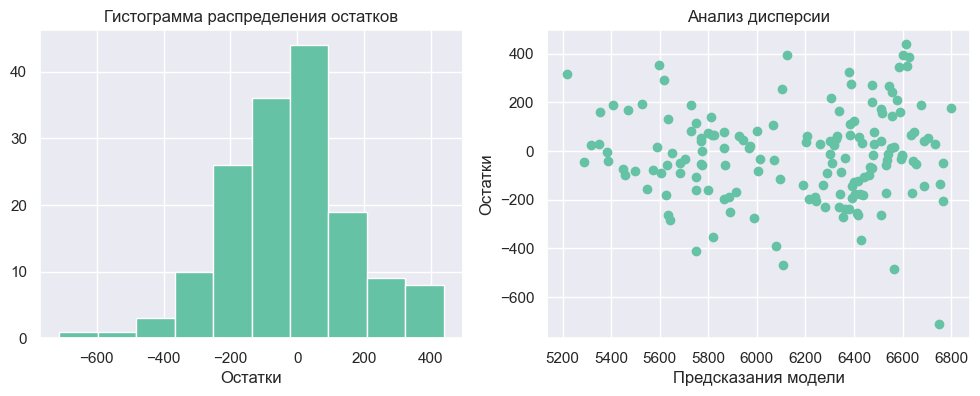

In [111]:
residues_third = y_test - predictions_third

plot_residues(residues_third, predictions_third)

In [112]:
mse_third = mean_squared_error(y_test, predictions_third)
rmse_third = mean_squared_error(y_test, predictions_third, squared=False)
mae_third = mean_absolute_error(y_test, predictions_third)

In [113]:
get_params(model_lr_third, scaler_third, encoder_third, predictions_third, r2_third, 
           mse_third, rmse_third, mae_third, residues_third, 'third')

**На основании обучения можно сделать вывод:**
- R² = 0.83, данное значение довольно близко к единице, поэтому модель предсказывает довольно точно, однако есть простор для улучшения модели
- Из распределения остатков можно сделать вывод, что оно имеет смещенное нормальное распределение, что говорит о том, что большую часть значений модель предсказала верно
- На графике диспресии представлена почти нормальная дисперсия остатков

Полученные остатки и дисперсия очень похожа на полученные у второй модели

4. Сравните качество трёх моделей линейной регрессии, сопоставьте их R² и остатки.

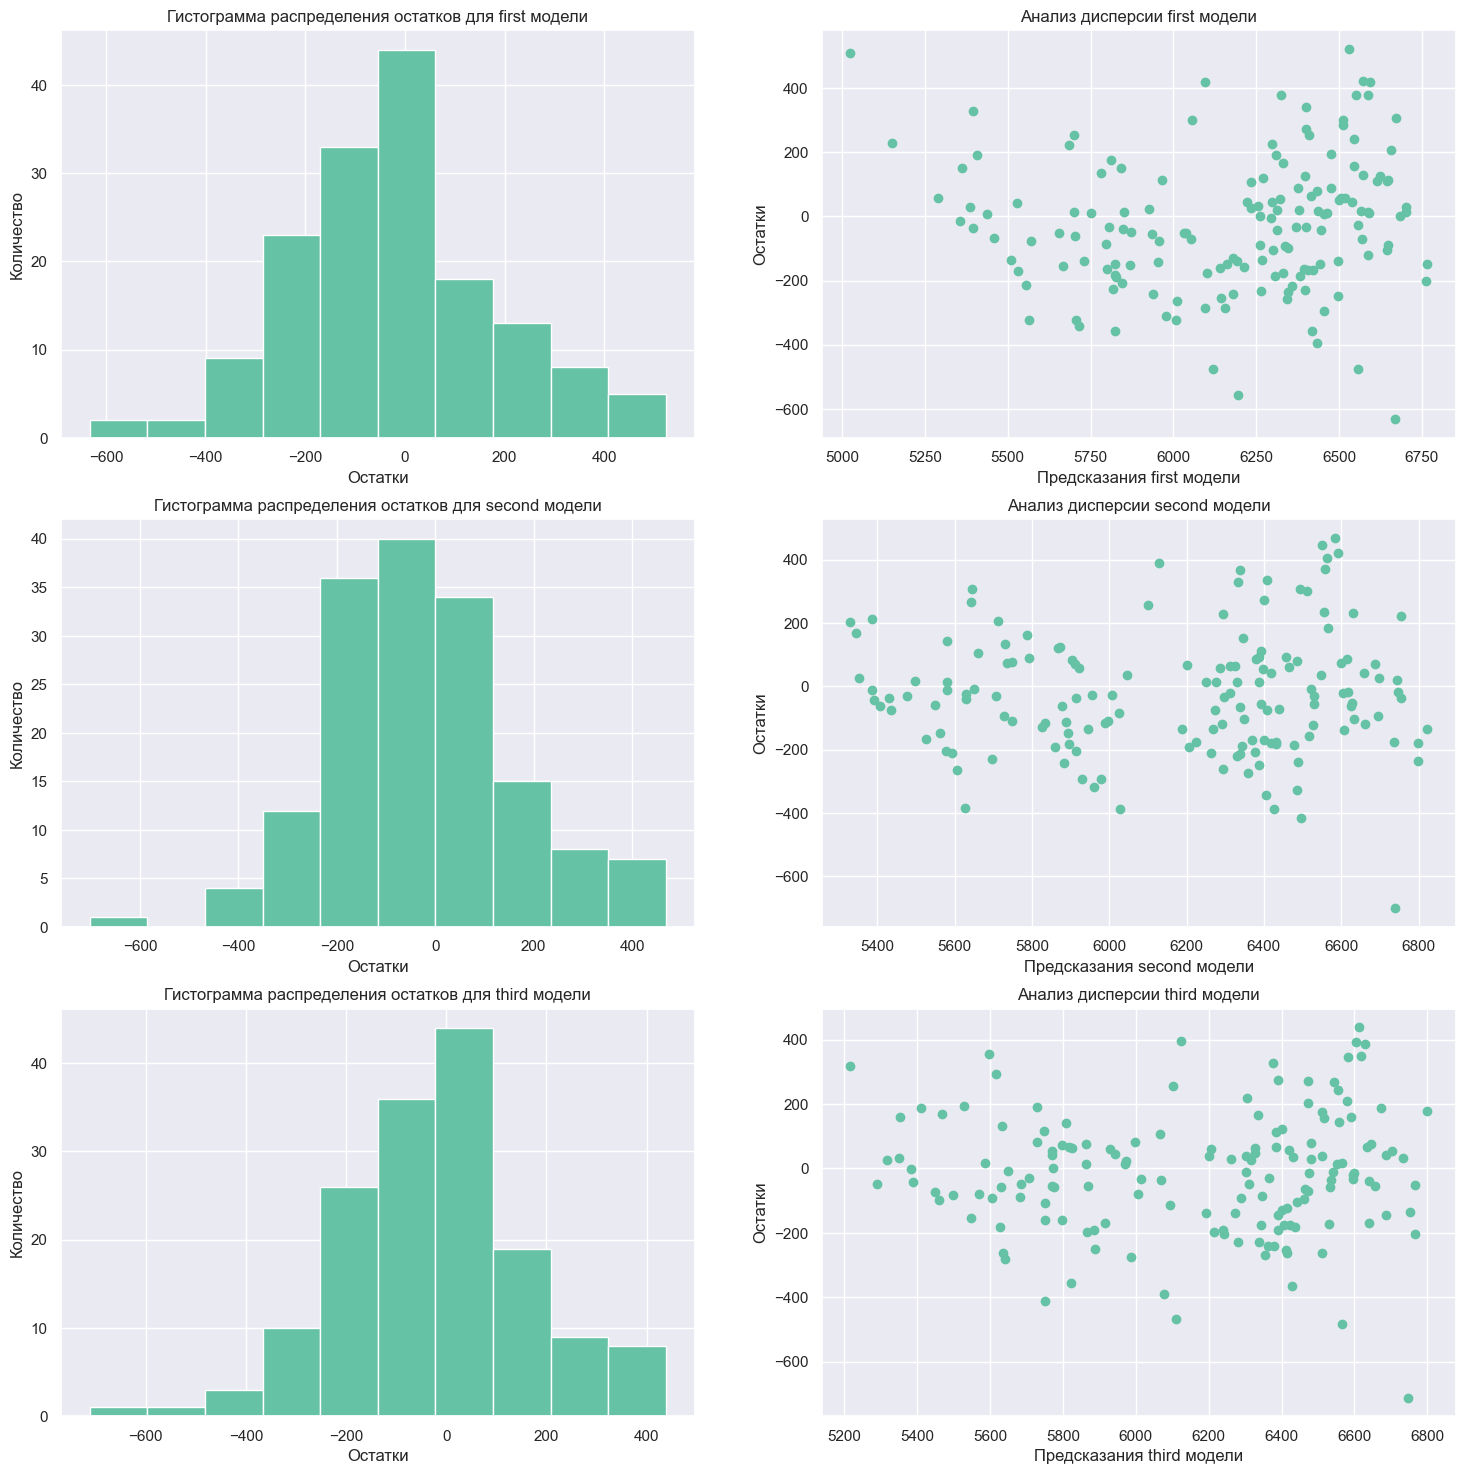

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
for num, model in enumerate(['first', 'second', 'third']):
    axes[num][0].set_title(f'Гистограмма распределения остатков для {model} модели')
    axes[num][0].set_xlabel('Остатки')
    axes[num][0].set_ylabel('Количество')
    axes[num][0].hist(models[model]['residues'])
    
    axes[num][1].set_xlabel(f'Предсказания {model} модели')
    axes[num][1].set_ylabel('Остатки')
    axes[num][1].set_title(f'Анализ дисперсии {model} модели')
    axes[num][1].scatter(x=models[model]['predictions'], y=models[model]['residues'])

5. Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используйте функции для расчёта метрик. Укажите:
    - лучшую модель;
    - доверительный интервал прогноза лучшей модели.

In [115]:
def find_min_metrics(metric, dictionary = models):
    min_value = np.inf
    min_model = None
    
    for key in dictionary.keys():
        value = dictionary[key][metric]
        
        if value < min_value:
            min_value = value
            min_model = key
    
    return round(min_value, 2), min_model

In [116]:
print(f'Лучший показатель MSE и модель соответственно: {find_min_metrics("mse")}')

Лучший показатель MSE и модель соответственно: (35316.0, 'third')


In [117]:
print(f'Лучший показатель MAE и модель соответственно: {find_min_metrics("mae")}')

Лучший показатель MAE и модель соответственно: (144.64, 'third')


In [118]:
print(f'Лучший показатель RMSE и модель соответственно: {find_min_metrics("rmse")}')

Лучший показатель RMSE и модель соответственно: (187.93, 'third')


In [119]:
max_r2 = -np.inf
best_model_r2 = None

for key in models.keys():
    r2 = models[key]['r2']

    if r2 > max_r2:
        max_r2 = r2
        best_model_r2 = key
        
print(f'Лучший показатель метрики R² {round(max_r2, 2)} у {best_model_r2} модели')

Лучший показатель метрики R² 0.83 у third модели


По всем показателям лучшей моделю оказалась третья модель. Найдем доверительный интервал лучшей модели

In [120]:
st.norm.interval(confidence=0.99, 
                 loc=np.mean(predictions_third), 
                 scale=st.sem(predictions_third))

(6074.4395386352835, 6243.10958881161)

6. С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете `cow_buy.csv`.
    - Добавьте недостающие признаки `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)`: возьмите из датасета `ferma_main.csv` средние значения каждого из признаков и увеличьте их на 5%.
    - Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
    - Получите прогноз удоя коров.

In [121]:
cow_buy.reset_index(drop=True, inplace=True)

In [122]:
for feature in ['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio']:
    cow_buy[feature] = 1.05 * ferma[feature].mean()

In [123]:
cow_buy['spr_bin'] = cow_buy['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)

In [124]:
cow_buy['efu_squared'] = cow_buy['energy_feed_unit'] ** 2

In [125]:
test_categorial = pd.DataFrame(encoder_third.transform(cow_buy[categorial_feature.keys()]),
                               columns=encoder_third.get_feature_names_out())

In [126]:
test_numerical = pd.DataFrame(scaler_third.transform(cow_buy[numerical_feature.keys()]),
                             columns=numerical_feature.keys())

In [127]:
test = pd.concat([test_categorial, test_numerical], axis=1)

In [128]:
predictions = pd.DataFrame(model_lr_third.predict(test), columns=['yield_kg'])

In [129]:
result = pd.concat([cow_buy, predictions], axis=1)

In [130]:
result.sort_values(by='yield_kg', ascending=False)

breed pasture_type bull_father_breed  dad_name  fat_content_now  \
0    Вис Бик Айдиал    холмистое            Айдиал  Геркулес             3.58   
10   Вис Бик Айдиал    холмистое            Айдиал  Геркулес             3.68   
3   РефлешнСоверинг    холмистое            Айдиал    Буйный             3.40   
12  РефлешнСоверинг    холмистое            Айдиал    Буйный             3.40   
9   РефлешнСоверинг    равнинное           Соверин  Геркулес             3.73   
4   РефлешнСоверинг    равнинное            Айдиал    Буйный             3.64   
6    Вис Бик Айдиал    равнинное           Соверин    Буйный             3.57   
15   Вис Бик Айдиал    равнинное           Соверин    Буйный             3.34   
7   РефлешнСоверинг    холмистое            Айдиал    Буйный             3.40   
5   РефлешнСоверинг    равнинное           Соверин  Геркулес             3.63   
14  РефлешнСоверинг    равнинное           Соверин  Геркулес             3.77   
8    Вис Бик Айдиал    холмистое           Соверин  Соловчик             3.73   
13   Вис Бик Айдиал    холмистое           Соверин  Соловчик             3.73   
1    Вис Бик Айдиал    равнинное           Соверин    Буйный             3.54   
2   РефлешнСоверинг    равнинное           Соверин     Барин             3.59   
11   Вис Бик Айдиал    холмистое           Соверин     Барин             3.42   

    protein_now          age  energy_feed_unit  crude_protein_g  \
0         3.076  более_2_лет         15.276162      2019.947532   
10        3.046  более_2_лет         15.276162      2019.947532   
3         3.061  более_2_лет         15.276162      2019.947532   
12        3.065  более_2_лет         15.276162      2019.947532   
9         3.073  более_2_лет         15.276162      2019.947532   
4         3.074  более_2_лет         15.276162      2019.947532   
6         3.079  более_2_лет         15.276162      2019.947532   
15        3.069  более_2_лет         15.276162      2019.947532   
7         3.079  менее_2_лет         15.276162      2019.947532   
5         3.053  менее_2_лет         15.276162      2019.947532   
14        3.053  менее_2_лет         15.276162      2019.947532   
8         3.055  более_2_лет         15.276162      2019.947532   
13        3.079  более_2_лет         15.276162      2019.947532   
1         3.081  менее_2_лет         15.276162      2019.947532   
2         3.074  более_2_лет         15.276162      2019.947532   
11        3.075  менее_2_лет         15.276162      2019.947532   

    sugar_protein_ratio  spr_bin  efu_squared     yield_kg  
0              0.958744        1   233.361138  6608.443615  
10             0.958744        1   233.361138  6608.443615  
3              0.958744        1   233.361138  6592.027874  
12             0.958744        1   233.361138  6592.027874  
9              0.958744        1   233.361138  6574.182798  
4              0.958744        1   233.361138  6543.028775  
6              0.958744        1   233.361138  6528.290493  
15             0.958744        1   233.361138  6528.290493  
7              0.958744        1   233.361138  6398.012445  
5              0.958744        1   233.361138  6380.167370  
14             0.958744        1   233.361138  6380.167370  
8              0.958744        1   233.361138  6338.844151  
13             0.958744        1   233.361138  6338.844151  
1              0.958744        1   233.361138  6334.275064  
2              0.958744        1   233.361138  6281.140194  
11             0.958744        1   233.361138  6121.385582

Сделан прогноз удоя и выведена информация о коровах, в порядке убывния спрогнозированного удоя

**Вывод**:
- было обучено три модели линейной регрессии. Для улучшения показателей модели была проведена бинаризация признака СПО (Сахаро-протеиновое соотношение), а так же возведение в квадрат ЭКЕ (Энергетическая кормовая единица). В результате модель имеет лучшие показатели:
    - MSE: 35316
    - MAE: 144.64
    - RMSE: 187.93
    - R²: 0.83
- Для каждой из моделей построены графики остатков и дисперсия. Для лучшей модели получена нормально распределенная диаграмма остатков и нормальная дисперсия остатков
- Для коров, которые хочет купить фермер была проведена трансформация категориальных и количественных признаков, обученных для третьей модели.

## Обучение модели логистической регрессии

1. Подготовьте данные датасета `ferma_main.csv` и обучите на них модель `LogisticRegression`.
    - Используйте в качестве целевого признак `Вкус молока`.
    - При необходимости преобразуйте имеющиеся или добавьте новые признаки.
    - Разбейте данные на тренировочную и тестовую выборки.
    - Кодируйте категориальные признаки с помощью `OneHotEncoder`.
    - Масштабируйте количественные признаки с помощью `StandardScaler`.
    - Обучите модель логистической регрессии на подготовленных данных.
    - Оцените качество модели на тестовой выборке: рассчитайте метрики accuracy, recall, precision.
    - Постройте матрицу ошибок.

In [131]:
X_milk = ferma.drop(['id', 'yield_kg', 'milk_taste', 'breed', 'bull_father_breed', 'spr_bin', 'efu_squared'], axis=1)
y_milk = ferma['milk_taste']

In [132]:
le_1 = LabelEncoder()
le_2= LabelEncoder()
y_milk_label = le_1.fit_transform(y_milk)
y_milk = pd.Series(le_2.fit_transform(-y_milk_label))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X_milk, 
    y_milk, 
    random_state=RANDOM_STATE,
    stratify=y_milk)

In [134]:
categorial_milk = ['pasture_type', 'age']

In [135]:
numerical_milk = ['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_content', 'protein']

In [136]:
encoder_milk = OneHotEncoder(drop='first', sparse_output=False)

ohe_train = pd.DataFrame(encoder_milk.fit_transform(X_train[categorial_milk]), 
                         columns=encoder_milk.get_feature_names_out())
ohe_test = pd.DataFrame(encoder_milk.transform(X_test[categorial_milk]),
                        columns=encoder_milk.get_feature_names_out())

In [137]:
scaler_milk = StandardScaler()

scale_train = pd.DataFrame(scaler_milk.fit_transform(X_train[numerical_milk]),
                         columns=numerical_milk)
scale_test = pd.DataFrame(scaler_milk.transform(X_test[numerical_milk]),
                         columns=numerical_milk)

In [138]:
X_train = pd.concat([ohe_train, scale_train], axis=1)
X_test = pd.concat([ohe_test, scale_test], axis=1)

In [139]:
model_lr_milk = LogisticRegression()

model_lr_milk.fit(X_train, y_train)
milk_pred = model_lr_milk.predict(X_test)

In [140]:
y_proba = model_lr_milk.predict_proba(X_test)[:,1]

2. Проанализируйте модель логистической регрессии.
    - Объясните, какая ошибка критичнее всего при покупке коров: первого или второго рода. Помните, что главное для заказчика — вкусное молоко. Сформулируйте ответ с учётом метрик recall и precision, выберите более важную из них.
    - Сведите критичную ошибку к нулю: для этого измените порог принадлежности к классам. Ещё раз рассчитайте значения метрик recall и precision. Какое значение порога вы выбрали? Как изменились значения метрик?
    - Оформите выводы: скажите, что нужно сделать дальше, исходя из анализа модели?

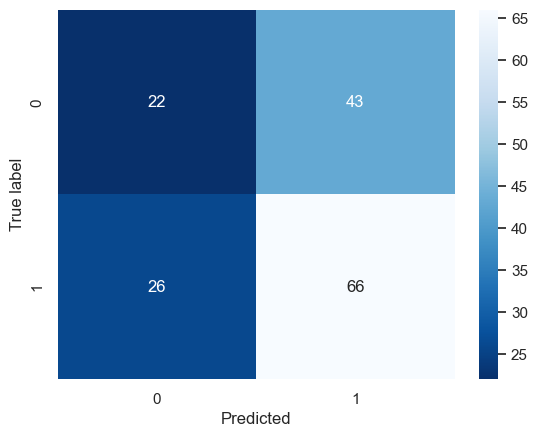

In [141]:
cm = confusion_matrix(y_test, milk_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [142]:
f'Accuracy для модели: {round(accuracy_score(y_test, milk_pred), 2)}'

'Accuracy для модели: 0.56'

In [143]:
f'Полнота модели: {round(recall_score(y_test, milk_pred), 2)}'

'Полнота модели: 0.72'

In [144]:
f'Точность присвоения TP модели: {round(precision_score(y_test, milk_pred), 2)}'

'Точность присвоения TP модели: 0.61'

Поскольку нам необходимо купить корову с вкусным молоком, нам необходимо уменьшить количество "Ложно вкусных" коров. Покупка коровы с невкусным молоком будет более критична, чем не покупка коровы с вкусным молоком, поэтому надо уменьшить количество ошибок первого рода. По этом причине стоит опираться на метрику percision, поскольку именно она показывает количество ложно положительных результатов.

Поэтому нам необходимо поднять порог вкусного молока

In [145]:
y_probs = model_lr_milk.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
data = pd.DataFrame([precision, thresholds], index=['precision', 'thresholds']).transpose().sort_values(by='precision', ascending=False)
data.head(25)

precision  thresholds
157   1.000000         NaN
151   1.000000    0.839402
145   1.000000    0.782803
146   1.000000    0.799918
147   1.000000    0.803105
148   1.000000    0.819708
150   1.000000    0.835730
149   1.000000    0.830399
152   1.000000    0.843192
153   1.000000    0.844330
154   1.000000    0.847171
155   1.000000    0.847526
156   1.000000    0.858341
143   0.928571    0.779179
144   0.923077    0.779194
124   0.878788    0.725870
125   0.875000    0.730111
126   0.870968    0.736395
142   0.866667    0.777997
127   0.866667    0.741249
128   0.862069    0.745324
136   0.857143    0.762171
129   0.857143    0.750054
123   0.852941    0.724999
130   0.851852    0.757062

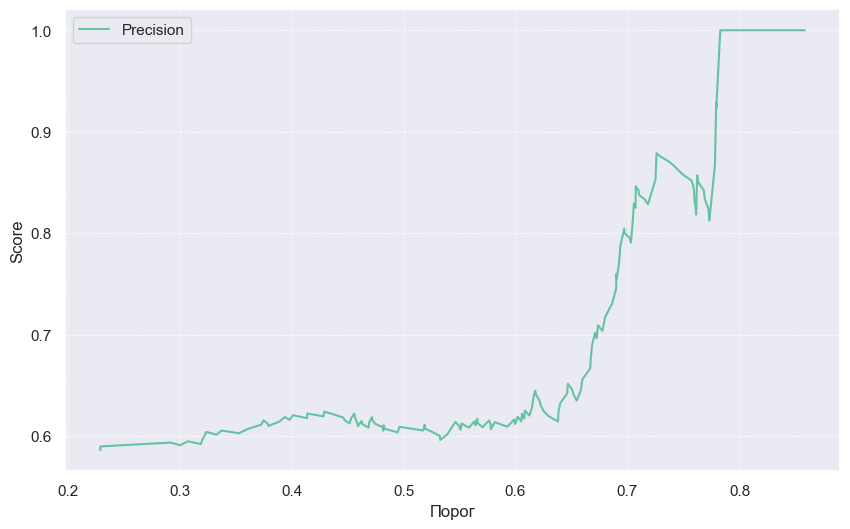

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Порог')
plt.ylabel('Score')
plt.legend()  # Устанавливаем интервалы значений по оси y
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

In [147]:
model_lr_milk.threshold = 0.7

In [148]:
y_pred_with_threshold = (y_probs >= model_lr_milk.threshold).astype(int)

In [149]:
precision_score(y_test, y_pred_with_threshold)

0.7954545454545454

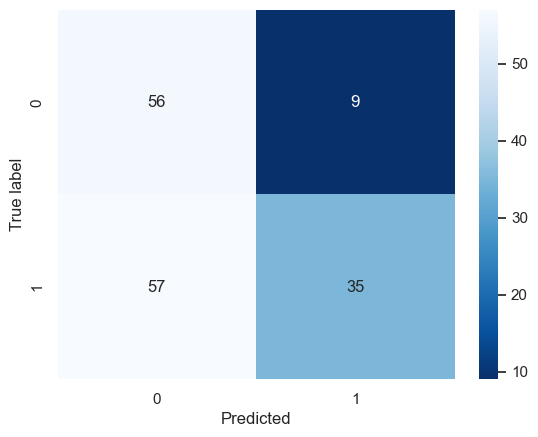

In [150]:
cm = confusion_matrix(y_test, y_pred_with_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

3. С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете `cow_buy.csv`.
    - Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
    - Получите прогноз вкуса молока коров.

In [151]:
cow_buy.columns

Index(['breed', 'pasture_type', 'bull_father_breed', 'dad_name',
       'fat_content_now', 'protein_now', 'age', 'energy_feed_unit',
       'crude_protein_g', 'sugar_protein_ratio', 'spr_bin', 'efu_squared'],
      dtype='object')

In [152]:
cow_buy.rename(columns={'fat_content_now': 'fat_content',
               'protein_now': 'protein'}, inplace=True)

In [153]:
cow_categorial_milk = pd.DataFrame(encoder_milk.transform(cow_buy[categorial_milk]),
                                   columns=encoder_milk.get_feature_names_out())
cow_numerical_milk = pd.DataFrame(scaler_milk.fit_transform(cow_buy[numerical_milk]),
                                  columns=numerical_milk)
cow_milk = pd.concat([cow_categorial_milk, cow_numerical_milk], axis=1)

In [154]:
cow_milk

pasture_type_холмистое  age_менее_2_лет  energy_feed_unit  \
0                      1.0              0.0               0.0   
1                      0.0              1.0               0.0   
2                      0.0              0.0               0.0   
3                      1.0              0.0               0.0   
4                      0.0              0.0               0.0   
5                      0.0              1.0               0.0   
6                      0.0              0.0               0.0   
7                      1.0              1.0               0.0   
8                      1.0              0.0               0.0   
9                      0.0              0.0               0.0   
10                     1.0              0.0               0.0   
11                     1.0              1.0               0.0   
12                     1.0              0.0               0.0   
13                     1.0              0.0               0.0   
14                     0.0              1.0               0.0   
15                     0.0              0.0               0.0   

    crude_protein_g  sugar_protein_ratio  fat_content   protein  
0               0.0                  0.0     0.059253  0.710628  
1               0.0                  0.0    -0.232455  1.169098  
2               0.0                  0.0     0.132181  0.527240  
3               0.0                  0.0    -1.253436 -0.664781  
4               0.0                  0.0     0.496816  0.527240  
5               0.0                  0.0     0.423889 -1.398332  
6               0.0                  0.0    -0.013674  0.985710  
7               0.0                  0.0    -1.253436  0.985710  
8               0.0                  0.0     1.153161 -1.214945  
9               0.0                  0.0     1.153161  0.435546  
10              0.0                  0.0     0.788525 -2.040190  
11              0.0                  0.0    -1.107582  0.618934  
12              0.0                  0.0    -1.253436 -0.298005  
13              0.0                  0.0     1.153161  0.985710  
14              0.0                  0.0     1.444870 -1.398332  
15              0.0                  0.0    -1.690999  0.068770

In [155]:
y_pred_probs_cow = model_lr_milk.predict_proba(cow_milk)[:, 1]
y_pred_cow = (y_pred_probs_cow >= model_lr_milk.threshold).astype(int)

In [156]:
cow_buy['milk_taste_sure'] = le_1.inverse_transform(-le_2.inverse_transform(y_pred_cow))

In [157]:
cow_buy

breed pasture_type bull_father_breed  dad_name  fat_content  \
0    Вис Бик Айдиал    холмистое            Айдиал  Геркулес         3.58   
1    Вис Бик Айдиал    равнинное           Соверин    Буйный         3.54   
2   РефлешнСоверинг    равнинное           Соверин     Барин         3.59   
3   РефлешнСоверинг    холмистое            Айдиал    Буйный         3.40   
4   РефлешнСоверинг    равнинное            Айдиал    Буйный         3.64   
5   РефлешнСоверинг    равнинное           Соверин  Геркулес         3.63   
6    Вис Бик Айдиал    равнинное           Соверин    Буйный         3.57   
7   РефлешнСоверинг    холмистое            Айдиал    Буйный         3.40   
8    Вис Бик Айдиал    холмистое           Соверин  Соловчик         3.73   
9   РефлешнСоверинг    равнинное           Соверин  Геркулес         3.73   
10   Вис Бик Айдиал    холмистое            Айдиал  Геркулес         3.68   
11   Вис Бик Айдиал    холмистое           Соверин     Барин         3.42   
12  РефлешнСоверинг    холмистое            Айдиал    Буйный         3.40   
13   Вис Бик Айдиал    холмистое           Соверин  Соловчик         3.73   
14  РефлешнСоверинг    равнинное           Соверин  Геркулес         3.77   
15   Вис Бик Айдиал    равнинное           Соверин    Буйный         3.34   

    protein          age  energy_feed_unit  crude_protein_g  \
0     3.076  более_2_лет         15.276162      2019.947532   
1     3.081  менее_2_лет         15.276162      2019.947532   
2     3.074  более_2_лет         15.276162      2019.947532   
3     3.061  более_2_лет         15.276162      2019.947532   
4     3.074  более_2_лет         15.276162      2019.947532   
5     3.053  менее_2_лет         15.276162      2019.947532   
6     3.079  более_2_лет         15.276162      2019.947532   
7     3.079  менее_2_лет         15.276162      2019.947532   
8     3.055  более_2_лет         15.276162      2019.947532   
9     3.073  более_2_лет         15.276162      2019.947532   
10    3.046  более_2_лет         15.276162      2019.947532   
11    3.075  менее_2_лет         15.276162      2019.947532   
12    3.065  более_2_лет         15.276162      2019.947532   
13    3.079  более_2_лет         15.276162      2019.947532   
14    3.053  менее_2_лет         15.276162      2019.947532   
15    3.069  более_2_лет         15.276162      2019.947532   

    sugar_protein_ratio  spr_bin  efu_squared milk_taste_sure  
0              0.958744        1   233.361138       не вкусно  
1              0.958744        1   233.361138       не вкусно  
2              0.958744        1   233.361138       не вкусно  
3              0.958744        1   233.361138       не вкусно  
4              0.958744        1   233.361138       не вкусно  
5              0.958744        1   233.361138       не вкусно  
6              0.958744        1   233.361138       не вкусно  
7              0.958744        1   233.361138          вкусно  
8              0.958744        1   233.361138       не вкусно  
9              0.958744        1   233.361138       не вкусно  
10             0.958744        1   233.361138       не вкусно  
11             0.958744        1   233.361138          вкусно  
12             0.958744        1   233.361138       не вкусно  
13             0.958744        1   233.361138       не вкусно  
14             0.958744        1   233.361138       не вкусно  
15             0.958744        1   233.361138       не вкусно

Все коровы кроме двух оказались с невкусным молоком. К покупке не рекомендуются коровы с невкусным молоком

**Вывод**:



В ходе работы была обучена модель Логистической регрессии. Поскольку у данных у коров одинаковые параметры, это могло повлиять на классификацию, а так же шумы в обучающей выборке повлияли на полученный результат

Поскольку ошибка для фермера покупки коровы с невкусным молоком довольно фатальна, то необходимо максимально убрать вероятность того, что молоко невкусное. Поэтому был подобран параметр, в котором значение ошибок первого рода максимально снижен. Порог классификации равен 0.7

В итоге для датасета коров к покупке найдено две коровы со вкусным молоком.

## Итоговые выводы

In [158]:
cow_buy = pd.concat([cow_buy, predictions], axis=1)

In [159]:
cow_buy.query('yield_kg > 6000 & milk_taste_sure == "вкусно"')

breed pasture_type bull_father_breed dad_name  fat_content  \
7   РефлешнСоверинг    холмистое            Айдиал   Буйный         3.40   
11   Вис Бик Айдиал    холмистое           Соверин    Барин         3.42   

    protein          age  energy_feed_unit  crude_protein_g  \
7     3.079  менее_2_лет         15.276162      2019.947532   
11    3.075  менее_2_лет         15.276162      2019.947532   

    sugar_protein_ratio  spr_bin  efu_squared milk_taste_sure     yield_kg  
7              0.958744        1   233.361138          вкусно  6398.012445  
11             0.958744        1   233.361138          вкусно  6121.385582

В ходе разработки модели не было найдено две коровы, которая бы удовлетворяла желаниям фермера

Возможно стоит подождать результатов того, как поменяется  `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` после того как заказчики выполнят изменение подхода к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.

Для улучшения качества регрессионной модели был использован подбор порога для устранения ошибок первого рода.